## Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска
## Задача — на базе датасета подготовить данные для построения модели оценки результатов госэкзамена по математике

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind


pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
pd.options.display.float_format = '{:,.2f}'.format


'''Функция построения "ящиков с усами"'''
def data_boxplot(column): # column - столбец номинативных данных
    fig, ax = plt.subplots(figsize=(14, 4))
    
    sns.boxplot(x=column, y='score',
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Распределение баллов по госэкзамену по математике в зависимости от параметра ' + column)
    
    plt.show()


'''Функция проверки статистической разницы в распределении оценок по номинативным признакам с помощью теста Стьюдента'''
def data_stat_dif(column): # column - столбец номинативных данных
    cols = stud_math.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
                     <= 0.05/len(combinations_all):  # Учёт поправки Бонферони
            print('Найдены статистически значимые различия для параметра', column)
            break
    
    else: print('Статистически значимые различия для параметра', column, 'не найдены')


'''Функция расчета границ выбросов'''
def board_blowout(stat): # stat - функция describe()
    b_b = []
    iqr = stat[6]-stat[4] # межквартильный размах
    
    b_b.append(stat[4] - 1.5*iqr) # нижняя граница
    b_b.append(stat[6] + 1.5*iqr) # верхняя граница
    
    return b_b # Границы выбросов


'''Функция выдачи количественных показателей'''
def prnt_quant(column): # column - столбец данных
    print('Количество пропущенных значений:',stud_math.loc[:, column].isnull().sum())
    print('\nКоличественные показатели:', stud_math.loc[:, column].value_counts(), sep='\n')

    
stud_math = pd.read_csv('stud_math.csv')

## ЭТАП 1
## Общий анализ датасета, подготовка данных для дальнейшей обработки

### Проверяем считываемость данных, смотрим, какие данные хранятся в файле, выводим название столбцов

In [2]:
display(stud_math.head())
stud_math.columns

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.00,4.00,at_home,teacher,course,mother,2.00,2.00,0.00,yes,no,no,no,yes,-6.00,yes,NaN,no,4.00,3.00,4.00,3.00,6.00,30.00
1,GP,F,17,U,GT3,NaN,1.00,1.00,at_home,other,course,father,1.00,2.00,0.00,no,yes,no,no,no,-6.00,yes,yes,no,5.00,3.00,3.00,3.00,4.00,30.00
2,GP,F,15,U,LE3,T,1.00,1.00,at_home,other,other,mother,1.00,2.00,3.00,yes,no,NaN,no,yes,-6.00,yes,yes,NaN,4.00,3.00,2.00,3.00,10.00,50.00
3,GP,F,15,U,GT3,T,4.00,2.00,health,NaN,home,mother,1.00,3.00,0.00,no,yes,yes,yes,yes,-9.00,yes,yes,yes,3.00,2.00,2.00,5.00,2.00,75.00
4,GP,F,16,U,GT3,T,3.00,3.00,other,other,home,father,1.00,2.00,0.00,no,yes,yes,no,yes,-6.00,yes,no,no,4.00,3.00,2.00,5.00,4.00,50.00


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

### Для удобства использования частично заменям название столбцов, выводим для проверки таблицу и информацию о данных для первичного анализа

In [3]:
'''Для удобства использования частично заменям название столбцов'''
stud_math.rename(columns={'famsize': 'fam_size', 'Pstatus': 'p_status', 'Medu': 'm_edu', 'Fedu': 'f_edu',
                          'Mjob': 'm_job', 'Fjob': 'f_job', 'traveltime': 'travel_time', 'studytime': 'study_time',
                          'schoolsup': 'school_sup', 'famsup': 'fam_sup', 'studytime, granular': 'std_time_gnr',
                          'famrel': 'fam_rel', 'freetime': 'free_time', 'goout': 'go_out'}, inplace=True)

In [4]:
display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,std_time_gnr,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.00,4.00,at_home,teacher,course,mother,2.00,2.00,0.00,yes,no,no,no,yes,-6.00,yes,NaN,no,4.00,3.00,4.00,3.00,6.00,30.00
1,GP,F,17,U,GT3,NaN,1.00,1.00,at_home,other,course,father,1.00,2.00,0.00,no,yes,no,no,no,-6.00,yes,yes,no,5.00,3.00,3.00,3.00,4.00,30.00
2,GP,F,15,U,LE3,T,1.00,1.00,at_home,other,other,mother,1.00,2.00,3.00,yes,no,NaN,no,yes,-6.00,yes,yes,NaN,4.00,3.00,2.00,3.00,10.00,50.00
3,GP,F,15,U,GT3,T,4.00,2.00,health,NaN,home,mother,1.00,3.00,0.00,no,yes,yes,yes,yes,-9.00,yes,yes,yes,3.00,2.00,2.00,5.00,2.00,75.00
4,GP,F,16,U,GT3,T,3.00,3.00,other,other,home,father,1.00,2.00,0.00,no,yes,yes,no,yes,-6.00,yes,no,no,4.00,3.00,2.00,5.00,4.00,50.00
5,GP,M,16,U,LE3,T,4.00,3.00,services,other,reputation,mother,1.00,2.00,0.00,no,yes,yes,yes,yes,-6.00,yes,yes,no,5.00,4.00,2.00,5.00,10.00,75.00
6,GP,M,16,NaN,LE3,T,2.00,2.00,other,other,home,mother,1.00,2.00,0.00,no,no,no,no,yes,-6.00,yes,yes,no,4.00,4.00,4.00,3.00,0.00,55.00
7,GP,F,17,U,GT3,A,4.00,4.00,other,teacher,home,mother,2.00,2.00,0.00,yes,yes,no,no,yes,-6.00,yes,no,no,4.00,1.00,4.00,1.00,6.00,30.00
8,GP,M,15,U,LE3,A,3.00,2.00,services,other,home,mother,1.00,2.00,0.00,no,yes,yes,no,yes,-6.00,yes,yes,no,nan,2.00,2.00,1.00,0.00,95.00
9,GP,M,15,U,NaN,NaN,3.00,4.00,other,other,home,mother,1.00,2.00,0.00,no,yes,yes,yes,yes,-6.00,yes,yes,no,5.00,5.00,1.00,5.00,0.00,75.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   school        395 non-null    object 
 1   sex           395 non-null    object 
 2   age           395 non-null    int64  
 3   address       378 non-null    object 
 4   fam_size      368 non-null    object 
 5   p_status      350 non-null    object 
 6   m_edu         392 non-null    float64
 7   f_edu         371 non-null    float64
 8   m_job         376 non-null    object 
 9   f_job         359 non-null    object 
 10  reason        378 non-null    object 
 11  guardian      364 non-null    object 
 12  travel_time   367 non-null    float64
 13  study_time    388 non-null    float64
 14  failures      373 non-null    float64
 15  school_sup    386 non-null    object 
 16  fam_sup       356 non-null    object 
 17  paid          355 non-null    object 
 18  activities    381 non-null    

### Для удобства восприятия и наглядности выведем количество пропущенных значений по столбцам (параметрам):

In [5]:
'''Выдача количества пропущенных значений в столбцах'''
i = 0
miss_value_summ = 0
print('Количество пропущенных значений в столбцах:')

for column in stud_math.columns: # Цикл по столбцам
    i += 1
    curr_summ = stud_math.loc[:, column].isnull().sum() # Количество пропущенных значений 
    print(i, column, '-', curr_summ)

    miss_value_summ += curr_summ # Подсчет суммарного количества пропущенных значений 

print('\nОбщее количество пропущенных значений в столбцах:', miss_value_summ)

Количество пропущенных значений в столбцах:
1 school - 0
2 sex - 0
3 age - 0
4 address - 17
5 fam_size - 27
6 p_status - 45
7 m_edu - 3
8 f_edu - 24
9 m_job - 19
10 f_job - 36
11 reason - 17
12 guardian - 31
13 travel_time - 28
14 study_time - 7
15 failures - 22
16 school_sup - 9
17 fam_sup - 39
18 paid - 40
19 activities - 14
20 nursery - 16
21 std_time_gnr - 7
22 higher - 20
23 internet - 34
24 romantic - 31
25 fam_rel - 27
26 free_time - 11
27 go_out - 8
28 health - 15
29 absences - 12
30 score - 6

Общее количество пропущенных значений в столбцах: 565


## Предварительные выводы по датасету:
### 1. Датасет состоит 30 столбцов: 13 числовых и 17 строковых
### 2. Датасет содержит записи по 395 учащимся  
### 3. Полностью заполнены только три первых столбца (школа, пол и возраст), остальные имеют пропуски. Всего пропущено 565 значений, что составляет менее 0,05% от общего количества. Заполнить пропуски на данный момент не представляется возможным, так как вариантов для заполнения слишком много
##  

## ЭТАП 2
## Анализ  и очистка количественных показателей

### Первоначально проанализируем основной показатель датасета - успеваемость (score)

In [6]:
'''Проверка показателей параметра score (баллы по госэкзамену по математике)'''
prnt_quant('score') # Выдача количественных показателей столбца

Количество пропущенных значений: 6

Количественные показатели:
50.00     54
55.00     46
0.00      37
75.00     33
65.00     31
40.00     31
60.00     31
70.00     27
45.00     27
80.00     16
30.00     15
90.00     12
35.00      9
25.00      7
85.00      6
95.00      5
100.00     1
20.00      1
Name: score, dtype: int64


### Данные достаточно полные, имеется всего 6 пропущенных значений.  У 37 учеников итоговый балл по математике равен "нулю". Крайне маловероятно, что почти 10% учеников получили "нулевую" оценку. Хотя бы 1 балл, но они должны были набрать (ну, не совсем же они тупые!!!). При этом мы видим, что самый "неуспешный" ученик набрал минимум 20 баллов. Если дополнительно проанализировать информацию о "нулевых" учениках, то увидим, что большинство из них не пропускали занятия и хотят получить высшее образование. Из этого можно сделать вывод, что, скорее всего, данные ученики либо ещё не сдавали госэкзамен (что вероятнее всего), либо их результаты ещё не заненсены в таблицу 
### Посмотрим на распределение и статистические показатели:

Статистические показатели:
count   389.00
mean     52.26
std      22.92
min       0.00
25%      40.00
50%      55.00
75%      70.00
max     100.00
Name: score, dtype: float64


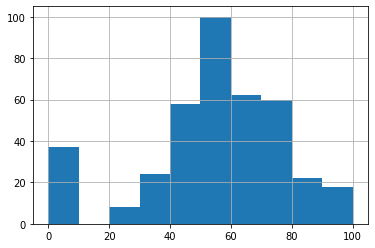

In [7]:
print('Статистические показатели:', stud_math.score.describe(), sep='\n')
stud_math.score.hist() # Строим гистограмму

### Гистограмма похожа на симметричную ("нормальную") форму распределения с подозрением на "выброс" в районе нуля. Однако, данный "выброс" укладывается в нижнюю границу выбросов (интервал "25% квартиль - 1,5 межквартильного расстояния" (40-(70-40)*1,5 = -5)), и теоретически этот "выброс" мы должны брать в обработку. 
### Теперь построим гистограмму успеваемости без учеников, имеющих "нулевые" оценки:

count   352.00
mean     57.76
std      16.20
min      20.00
25%      45.00
50%      55.00
75%      70.00
max     100.00
Name: score, dtype: float64

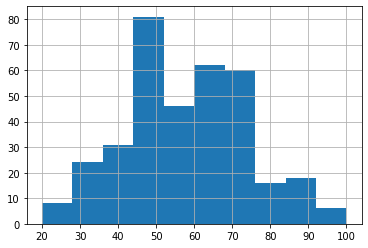

In [8]:
stud_math.score[stud_math.score>0].hist()
stud_math.score[stud_math.score>0].describe()

### Получили несколько иную картину: похожую на симметричную бимодальную форму распределения, при этом "нулевые" оценки уже выходят за рамки "percentile(25) -1.5*IQR" (45 -(70-45)**1,5 = 7,5) и могут классифицироваться, как выбросы. Данный подход не совсем корректен с точки зрения математики, однако, имеет право быть с точки зрения здравого смысла

### Посмотрим, объединяет ли что-нибудь учеников, имеющих "нулевые" отметки по математике:

In [9]:
stud_math.loc[stud_math.score == 0]

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,std_time_gnr,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
128,GP,M,18,R,NaN,T,2.00,2.00,NaN,other,reputation,mother,1.00,1.00,2.00,no,yes,no,yes,yes,-3.00,yes,yes,no,3.00,3.00,3.00,4.00,0.00,0.00
130,GP,F,15,R,GT3,T,3.00,4.00,services,teacher,course,father,2.00,3.00,2.00,no,yes,no,no,yes,-9.00,yes,yes,yes,4.00,2.00,2.00,5.00,0.00,0.00
131,GP,F,15,U,GT3,NaN,1.00,1.00,at_home,other,course,mother,3.00,1.00,0.00,no,yes,no,yes,no,-3.00,yes,yes,yes,4.00,nan,3.00,4.00,0.00,0.00
134,GP,M,15,R,GT3,T,3.00,4.00,at_home,teacher,course,mother,nan,2.00,0.00,no,yes,no,no,yes,-6.00,yes,no,yes,5.00,3.00,3.00,5.00,0.00,0.00
135,GP,F,15,U,GT3,T,4.00,4.00,services,NaN,course,mother,1.00,3.00,0.00,no,yes,no,yes,yes,-9.00,yes,yes,yes,4.00,3.00,3.00,5.00,0.00,0.00
136,GP,M,17,R,GT3,T,3.00,4.00,at_home,other,course,mother,3.00,2.00,0.00,no,no,NaN,no,yes,-6.00,yes,no,no,nan,4.00,5.00,5.00,0.00,0.00
137,GP,F,16,U,GT3,A,3.00,nan,other,other,NaN,other,nan,1.00,2.00,no,yes,no,yes,no,-3.00,yes,yes,yes,4.00,3.00,2.00,5.00,0.00,0.00
140,GP,M,15,U,GT3,T,4.00,3.00,teacher,services,NaN,father,2.00,4.00,0.00,yes,yes,no,NaN,yes,-12.00,yes,yes,no,2.00,2.00,2.00,3.00,0.00,0.00
144,GP,M,17,U,GT3,T,2.00,1.00,other,other,home,NaN,1.00,1.00,3.00,no,yes,no,no,yes,-3.00,yes,yes,no,5.00,4.00,5.00,5.00,0.00,0.00
146,GP,F,15,U,GT3,T,3.00,2.00,health,services,home,father,1.00,2.00,3.00,no,NaN,no,no,yes,-6.00,yes,yes,no,3.00,3.00,2.00,3.00,0.00,0.00


### Исходя из этой таблицы, возраст, пол и прочие условия жизни у учеников совершенно разные. Их может объединять только отсутствие дополнительной образовательной поддержки,но это на данный момент неважно

### По моему мнению, мы не должны брать учеников с "нулевым" результатом в расчёт, и они должны быть исключены из дальнейшего анализа. В данной работе мы оцениваем влияние условий жизни учащихся на их успеваемость, а при отсутствии успеваемости данное влияние мы проверить не сможем (теряется физический смысл работы). Скорее всего, потенциальные возможности исключённых из дальнейшей обработки учеников мы сможем оценить после построения соответствующей модели

### Исключаем из датасета записи с учениками, имеющими "нулевые" и пропущенные оценки по математике:

In [10]:
stud_math = stud_math.loc[stud_math.score > 0]

### Проверяем результат:

In [11]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   school        352 non-null    object 
 1   sex           352 non-null    object 
 2   age           352 non-null    int64  
 3   address       338 non-null    object 
 4   fam_size      328 non-null    object 
 5   p_status      311 non-null    object 
 6   m_edu         350 non-null    float64
 7   f_edu         331 non-null    float64
 8   m_job         335 non-null    object 
 9   f_job         320 non-null    object 
 10  reason        337 non-null    object 
 11  guardian      323 non-null    object 
 12  travel_time   329 non-null    float64
 13  study_time    345 non-null    float64
 14  failures      332 non-null    float64
 15  school_sup    343 non-null    object 
 16  fam_sup       316 non-null    object 
 17  paid          316 non-null    object 
 18  activities    340 non-null    

### Итак, у нас для дальнейшей работы осталось 352 записи
### Проверяем другие количественные показатели

In [12]:
'''Проверка показателей параметра age(возраст учеников)'''
prnt_quant('age') # Выдача количественных показателей столбца

Количество пропущенных значений: 0

Количественные показатели:
16    96
17    90
15    76
18    69
19    16
20     3
22     1
21     1
Name: age, dtype: int64


### Данные полные, пропущенных и незаполненных значений нет. Посмотрим на распределение и статистические показатели:

Статистические показатели:
count   352.00
mean     16.63
std       1.26
min      15.00
25%      16.00
50%      17.00
75%      18.00
max      22.00
Name: age, dtype: float64


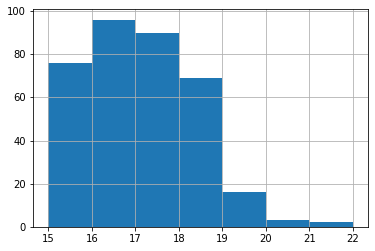

In [13]:
stat_age = stud_math.age.describe()
print('Статистические показатели:', stat_age, sep='\n')
stud_math.age.hist(bins=7) # Строим гистограмму

###  Гистограмма распределения параметра имеет нормальное распределение со смещением вправо с возможными выбросами в районе 21-22 лет. Основной возраст учеников 15-18 лет. Явный тренд на уменьшение количества возрастных учеников
### Проверяем данные на предмет выбросов:

In [14]:
print('25-й перцентиль: {},'.format(stat_age[4]), '75-й перцентиль: {},'.format(stat_age[6]), 
      "IQR: {}, ".format(stat_age[6]-stat_age[4]),"Границы выбросов: [{}, {}].".format(board_blowout(stat_age)[0], 
                                                                                     board_blowout(stat_age)[1]))

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


### Таким образом, данные достаточно чистые, имеется один несущественный выброс на самой границе диапазона - один ученик в возрасте 22-х лет не попадает в допустимый диапазон. Теоретически, можно не исключать данного ученика из обработки. Но для чистоты эксперимента проведём очистку:

In [15]:
stud_math = stud_math.loc[stud_math.age < 22]

In [16]:
'''Проверка показателей параметра m_edu (образование матери)'''
prnt_quant('m_edu') # Выдача количественных показателей столбца

Количество пропущенных значений: 2

Количественные показатели:
4.00    125
2.00     88
3.00     86
1.00     47
0.00      3
Name: m_edu, dtype: int64


### Первичный анализ показывает, что матерей, имеющих высшее образование, большее количество, при этом матерей, имеющих начальное и среднее образование, примерно поровну, без образования всего трое
### Данные в столбце m_edu практически полные, пропущенных значений всего 2, незаполненных нет
### Проверим распределение и статистические показатели:

Статистические показатели:
count   349.00
mean      2.81
std       1.09
min       0.00
25%       2.00
50%       3.00
75%       4.00
max       4.00
Name: m_edu, dtype: float64


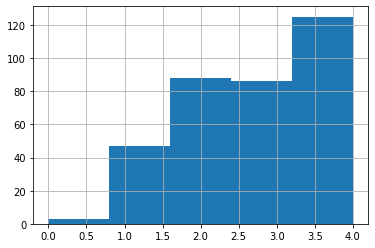

In [17]:
print('Статистические показатели:', stud_math.m_edu.describe(), sep='\n')
stud_math.m_edu.hist(bins=5) # Строим гистограмму

### Похоже на линейную зависимость: количество пропорционально качеству образования
### Вывод: данные чистые, без выбросов, дополнительной обработки не требуется
###  

In [18]:
'''Проверка показателей параметра f_edu (образование отца)'''
prnt_quant('f_edu') # Выдача количественных показателей столбца

Количество пропущенных значений: 21

Количественные показатели:
2.00     94
3.00     89
4.00     80
1.00     64
0.00      2
40.00     1
Name: f_edu, dtype: int64


### Выводы: 
#### - отцов, имеющих высшее, среднее и неполное среднее образования, примерно одинаковое количество. Без образования практически нет
#### - пропущенных значений 21, заполнить их не представляется возможным ввиду большого количества и отсутствия информации, незаполненных значений нет
#### - похоже, имеется один выброс
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   330.00
mean      2.66
std       2.33
min       0.00
25%       2.00
50%       3.00
75%       3.00
max      40.00
Name: f_edu, dtype: float64


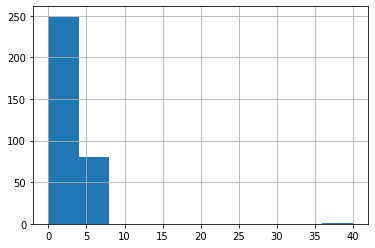

In [19]:
print('Статистические показатели:', stud_math.f_edu.describe(), sep='\n')
stud_math.f_edu.hist() # Строим гистограмму

### Действительно, имеется один явный выброс, равный 40. Вероятно, это ошибка при заведении данных, скорее всего, хотели завести 4. Исправляем:

In [20]:
stud_math.f_edu[stud_math.f_edu == 40] = 4

count   330.00
mean      2.55
std       1.08
min       0.00
25%       2.00
50%       3.00
75%       3.00
max       4.00
Name: f_edu, dtype: float64

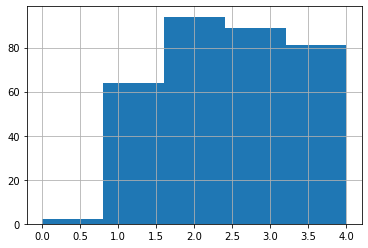

In [21]:
'''Проверяем...'''
stud_math.f_edu.hist(bins=5)
stud_math.f_edu.describe()

### Гистограмма похожа на нормальное распределение с небольшим смещением влево, тренд на увеличение количества с высшим образованием
###  Результат: данные очищены, дополнительной обработки не требуется

In [22]:
'''Проверка показателей параметра travel_time (время на дорогу)'''
prnt_quant('travel_time') # Выдача количественных показателей столбца

Количество пропущенных значений: 23

Количественные показатели:
1.00    218
2.00     86
3.00     17
4.00      7
Name: travel_time, dtype: int64


### Предварительный выводы: пропущенных значений 23, заполнить их не представляется возможным ввиду большого количества и отсутствия информации, незаполненных значений нет
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   328.00
mean      1.43
std       0.69
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       4.00
Name: travel_time, dtype: float64


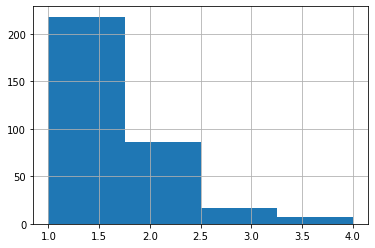

In [23]:
print('Статистические показатели:', stud_math.travel_time.describe(), sep='\n')
stud_math.travel_time.hist(bins=4) # Строим гистограмму

#### Похоже на экспоненту: функция количества учеников обратно пропорциональна квадрату (или кубу) времени на дорогу
### Выводы: 
#### - почти 60% учеников живут в непосредственной близости от школы, и только 7% учеников тратят на дорогу более 30 минут. Очевидно, что близость школы от дома или удобство дороги - один из главных критериев при выборе школы
#### - данные чистые, выбросы отсутствуют, дополнительной обработки данных не требуется
###  

In [24]:
'''Проверка показателей параметра study_time (время на учёбу помимо школы)'''
prnt_quant('study_time') # Выдача количественных показателей столбца

Количество пропущенных значений: 7

Количественные показатели:
2.00    173
1.00     89
3.00     58
4.00     24
Name: study_time, dtype: int64


### Предварительные выводы: пропущенных значений всего 7, незаполненных значений нет
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   344.00
mean      2.05
std       0.84
min       1.00
25%       1.00
50%       2.00
75%       2.00
max       4.00
Name: study_time, dtype: float64


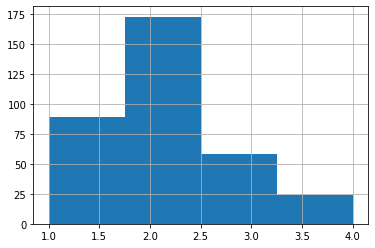

In [25]:
print('Статистические показатели:', stud_math.study_time.describe(), sep='\n')
stud_math.study_time.hist(bins=4)

### Нормальное распределение с трендом на уменьшение количества учеников, желающих тратить дополнительно на учёбу более 5 часов в день
### Выводы: 
#### - данные чистые, выбросы отсутствуют, дополнительной обработки данных не требуется
#### - 50% учеников тратят на учебу помимо школы, в-среднем, 2-5 часов в день, при этом немало и учеников (порядка 25%), которые на учёбу тратят менее 2 часов в день (лентяи или вундеркинды)
##  

In [26]:
'''Проверка параметров показателя studytime,granular'''
prnt_quant('std_time_gnr') # Выдача количественных показателей столбца

Количество пропущенных значений: 7

Количественные показатели:
-6.00     173
-3.00      89
-9.00      58
-12.00     24
Name: std_time_gnr, dtype: int64


### Данные достаточно полные (пропущенных значений всего 7), незаполненные значения отсутствуют
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   344.00
mean     -6.15
std       2.52
min     -12.00
25%      -6.00
50%      -6.00
75%      -3.00
max      -3.00
Name: std_time_gnr, dtype: float64


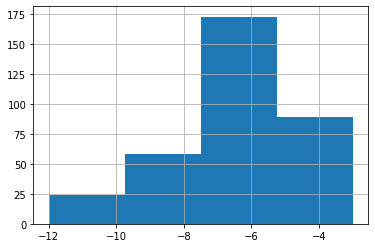

In [27]:
print('Статистические показатели:', stud_math.std_time_gnr.describe(), sep='\n')
stud_math.std_time_gnr.hist(bins=4) # Строим гистограмму

### Выводы: гистограмма распределения и количественные характеристики очень похожи на данные параметра study_time (проведем их анализ чуть позже). Данные чистые, без выбросов, дополнительной обработки данных не требуется
##  

In [28]:
'''Проверка параметра failures (внеучебные неудачи)'''
prnt_quant('failures') # Выдача количественных показателей столбца

Количество пропущенных значений: 20

Количественные показатели:
0.00    273
1.00     38
2.00     11
3.00      9
Name: failures, dtype: int64


### Данные достаточно полные (пропущенных значений всего 20), незаполненные значения отсутствуют
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   331.00
mean      0.26
std       0.65
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       3.00
Name: failures, dtype: float64


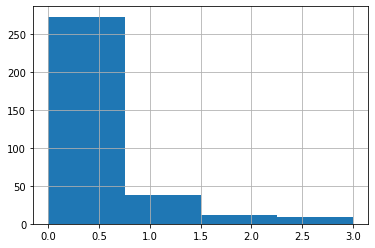

In [29]:
print('Статистические показатели:', stud_math.failures.describe(), sep='\n')
stud_math.failures.hist(bins=4) # Строим гистограмму

### Похоже на экспоненту: количество учеников, имеющих внеучебные неудачи, обратно пропорционально квадрату (или кубу) количества самих внеучебных неудач
### Выводы: 
#### - подавляющее число учащихся (более 80%) живут тихо и спокойно, без приключений
#### - данные чистые, без выбросов, дополнительной обработки данных не требуется
##  

In [30]:
'''Проверка параметра fam_rel (семейные отношения)'''
prnt_quant('fam_rel') # Выдача количественных показателей столбца

Количество пропущенных значений: 24

Количественные показатели:
4.00     163
5.00      87
3.00      56
2.00      14
1.00       6
-1.00      1
Name: fam_rel, dtype: int64


### Выводы: 
#### - ученики в-основном из благополучных семей, количество учеников из семей с отношеними "ниже среднего" составляет всего 6%
#### - количество пропущенных значений 24, незаполненных значений нет, подозрение на один выброс
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   327.00
mean      3.94
std       0.92
min      -1.00
25%       4.00
50%       4.00
75%       5.00
max       5.00
Name: fam_rel, dtype: float64


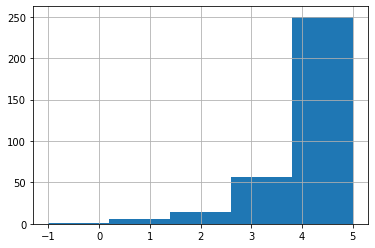

In [31]:
print('Статистические показатели:', stud_math.fam_rel.describe(), sep='\n')
stud_math.fam_rel.hist(bins=5) # Строим гистограмму

### Распределение экспонециальное. Имеется один очевидный выброс, который находится за пределами допустимых значений (от 1 до 5)
## Делаем его NaN:

In [32]:
stud_math.loc[stud_math.fam_rel == -1] = np.nan

'Статистические показатели:'

count   326.00
mean      3.95
std       0.88
min       1.00
25%       4.00
50%       4.00
75%       5.00
max       5.00
Name: fam_rel, dtype: float64

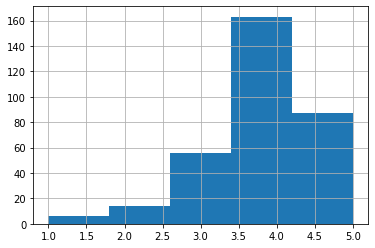

In [33]:
'''Проверяем:...'''
stud_math.fam_rel.hist(bins=5)
display('Статистические показатели:', stud_math.fam_rel.describe())

### Таким образом, получили смещенный слегка влево нормальный закон распределения, с трендом на увеличение количества семей с отношениями выше среднего
##  

In [34]:
'''Проверка параметра free_time (свободное время после школы)'''
prnt_quant('free_time') # Выдача количественных показателей столбца

Количество пропущенных значений: 9

Количественные показатели:
3.00    132
4.00    101
2.00     58
5.00     35
1.00     16
Name: free_time, dtype: int64


### Данные в столбце достаточно полные, незаполненных значений нет, количество пропущенных значений всего 9
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   342.00
mean      3.24
std       1.00
min       1.00
25%       3.00
50%       3.00
75%       4.00
max       5.00
Name: free_time, dtype: float64


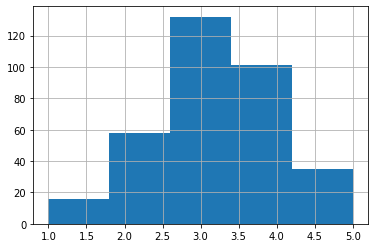

In [35]:
print('Статистические показатели:', stud_math.free_time.describe(), sep='\n')
stud_math.free_time.hist(bins=5) # Строим гистограмму

### Выводы: 
#### - нормальное распределение данных с небольшим смещением "вправо"
#### - данные чистые, выбросов нет, дополнительной обработки данных не требуется
###  

In [36]:
'''Проверка параметра go_out (проведение времени с друзьями)'''
prnt_quant('go_out') # Выдача количественных показателей столбца

Количество пропущенных значений: 7

Количественные показатели:
3.00    118
2.00     91
4.00     74
5.00     42
1.00     19
Name: go_out, dtype: int64


### Данные в столбце достаточно полные, незаполненных значений нет, количество пропущенных значений всего 7
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   344.00
mean      3.08
std       1.09
min       1.00
25%       2.00
50%       3.00
75%       4.00
max       5.00
Name: go_out, dtype: float64


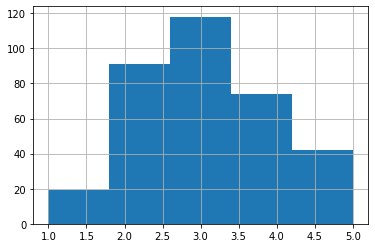

In [37]:
print('Статистические показатели:', stud_math.go_out.describe(), sep='\n')
stud_math.go_out.hist(bins=5) # Строим гистограмму

### Выводы: 
#### - нормальное распределение с небольшим смещением "вправо", тенденция на уменьшение количества времени, проведённого с друзьями
#### - данные чистые, выбросов нет, дополнительной обработки данных не требуется
###  

In [38]:
'''Проверка параметра health (здоровье)'''
prnt_quant('health') # Выдача количественных показателей столбца

Количество пропущенных значений: 14

Количественные показатели:
5.00    123
3.00     81
4.00     53
1.00     44
2.00     36
Name: health, dtype: int64


### Данные в столбце относительно полные, незаполненных значений нет, количество пропущенных значений всего 14
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   337.00
mean      3.52
std       1.41
min       1.00
25%       3.00
50%       4.00
75%       5.00
max       5.00
Name: health, dtype: float64


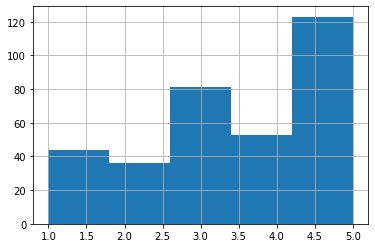

In [39]:
print('Статистические показатели:', stud_math.health.describe(), sep='\n')
stud_math.health.hist(bins=5)

### Выводы: 
#### - гистограмма похожа на линейный закон распределения данных: увеличение количества здоровых учеников
#### - достаточно много учеников (около 25%) с состоянием здоровья "ниже среднего"
#### - данные чистые, выбросов нет, дополнительной обработки данных не требуется
###  

In [40]:
'''Проверка параметра absences (количество пропущенных занятий)'''
prnt_quant('absences') # Выдача количественных показателей столбца

Количество пропущенных значений: 11

Количественные показатели:
0.00      74
2.00      60
4.00      52
6.00      30
8.00      20
10.00     17
12.00     12
14.00     11
3.00       7
16.00      6
7.00       6
18.00      5
5.00       5
20.00      4
22.00      3
9.00       3
1.00       3
15.00      2
13.00      2
11.00      2
25.00      1
54.00      1
385.00     1
26.00      1
56.00      1
24.00      1
212.00     1
21.00      1
75.00      1
30.00      1
19.00      1
38.00      1
40.00      1
23.00      1
17.00      1
28.00      1
Name: absences, dtype: int64


### Предварительный анализ: данные достаточно полные, пропущенных значений всего 11, имеются выбросы
### Проверяем распределение и статистические показатели:

Статистические показатели:
count   340.00
mean      8.05
std      24.77
min       0.00
25%       2.00
50%       4.00
75%       8.00
max     385.00
Name: absences, dtype: float64


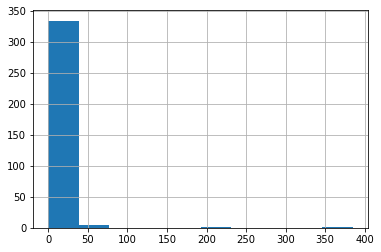

In [41]:
stat_abss = stud_math.absences.describe()
print('Статистические показатели:', stat_abss, sep='\n')
stud_math.absences.hist() # Строим гистограмму

### Рассчитаем границы выбросов и осуществим фильтрацию значений:

In [42]:
print('25-й перцентиль: {},'.format(stat_abss[4]), '75-й перцентиль: {},'.format(stat_abss[6]), 
      "IQR: {}, ".format(stat_abss[6]-stat_abss[4]),"Границы выбросов: [{}, {}].".format(board_blowout(stat_abss)[0], 
                                                                                       board_blowout(stat_abss)[1]))

25-й перцентиль: 2.0, 75-й перцентиль: 8.0, IQR: 6.0,  Границы выбросов: [-7.0, 17.0].


### Вывод: все значения параметра укладываются в нижнюю границу выбросов, за пределами верхней границы находится 27 записей (порядка 8% значений)
### Исключаем их из обработки:

Исключенных из обработки записей: 27


'Количественные показатели:'

0.00     74
2.00     60
4.00     52
6.00     30
8.00     20
10.00    17
12.00    12
14.00    11
3.00      7
7.00      6
16.00     6
5.00      5
1.00      3
9.00      3
11.00     2
13.00     2
15.00     2
17.00     1
Name: absences, dtype: int64

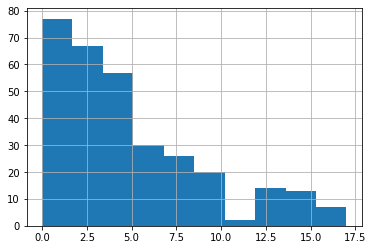

In [43]:
print('Исключенных из обработки записей:', stud_math.absences[stud_math.absences > 17].count())
stud_math = stud_math.loc[stud_math.absences < 18]
stud_math.absences.hist() # Строим гистограмму
display('Количественные показатели:', stud_math.absences.value_counts())

### Таким образом, у нас получилась гистограмма с практически линейным обратным распределением (количество прогулов обратно пропорционально их числу). При этом для дальнейшего анализа у нас остались в-основном записи, повторяющиеся не менее одного раза (число прогулов два и более). 

### Проведём корреляционный анализ столбцов с числовыми данными:

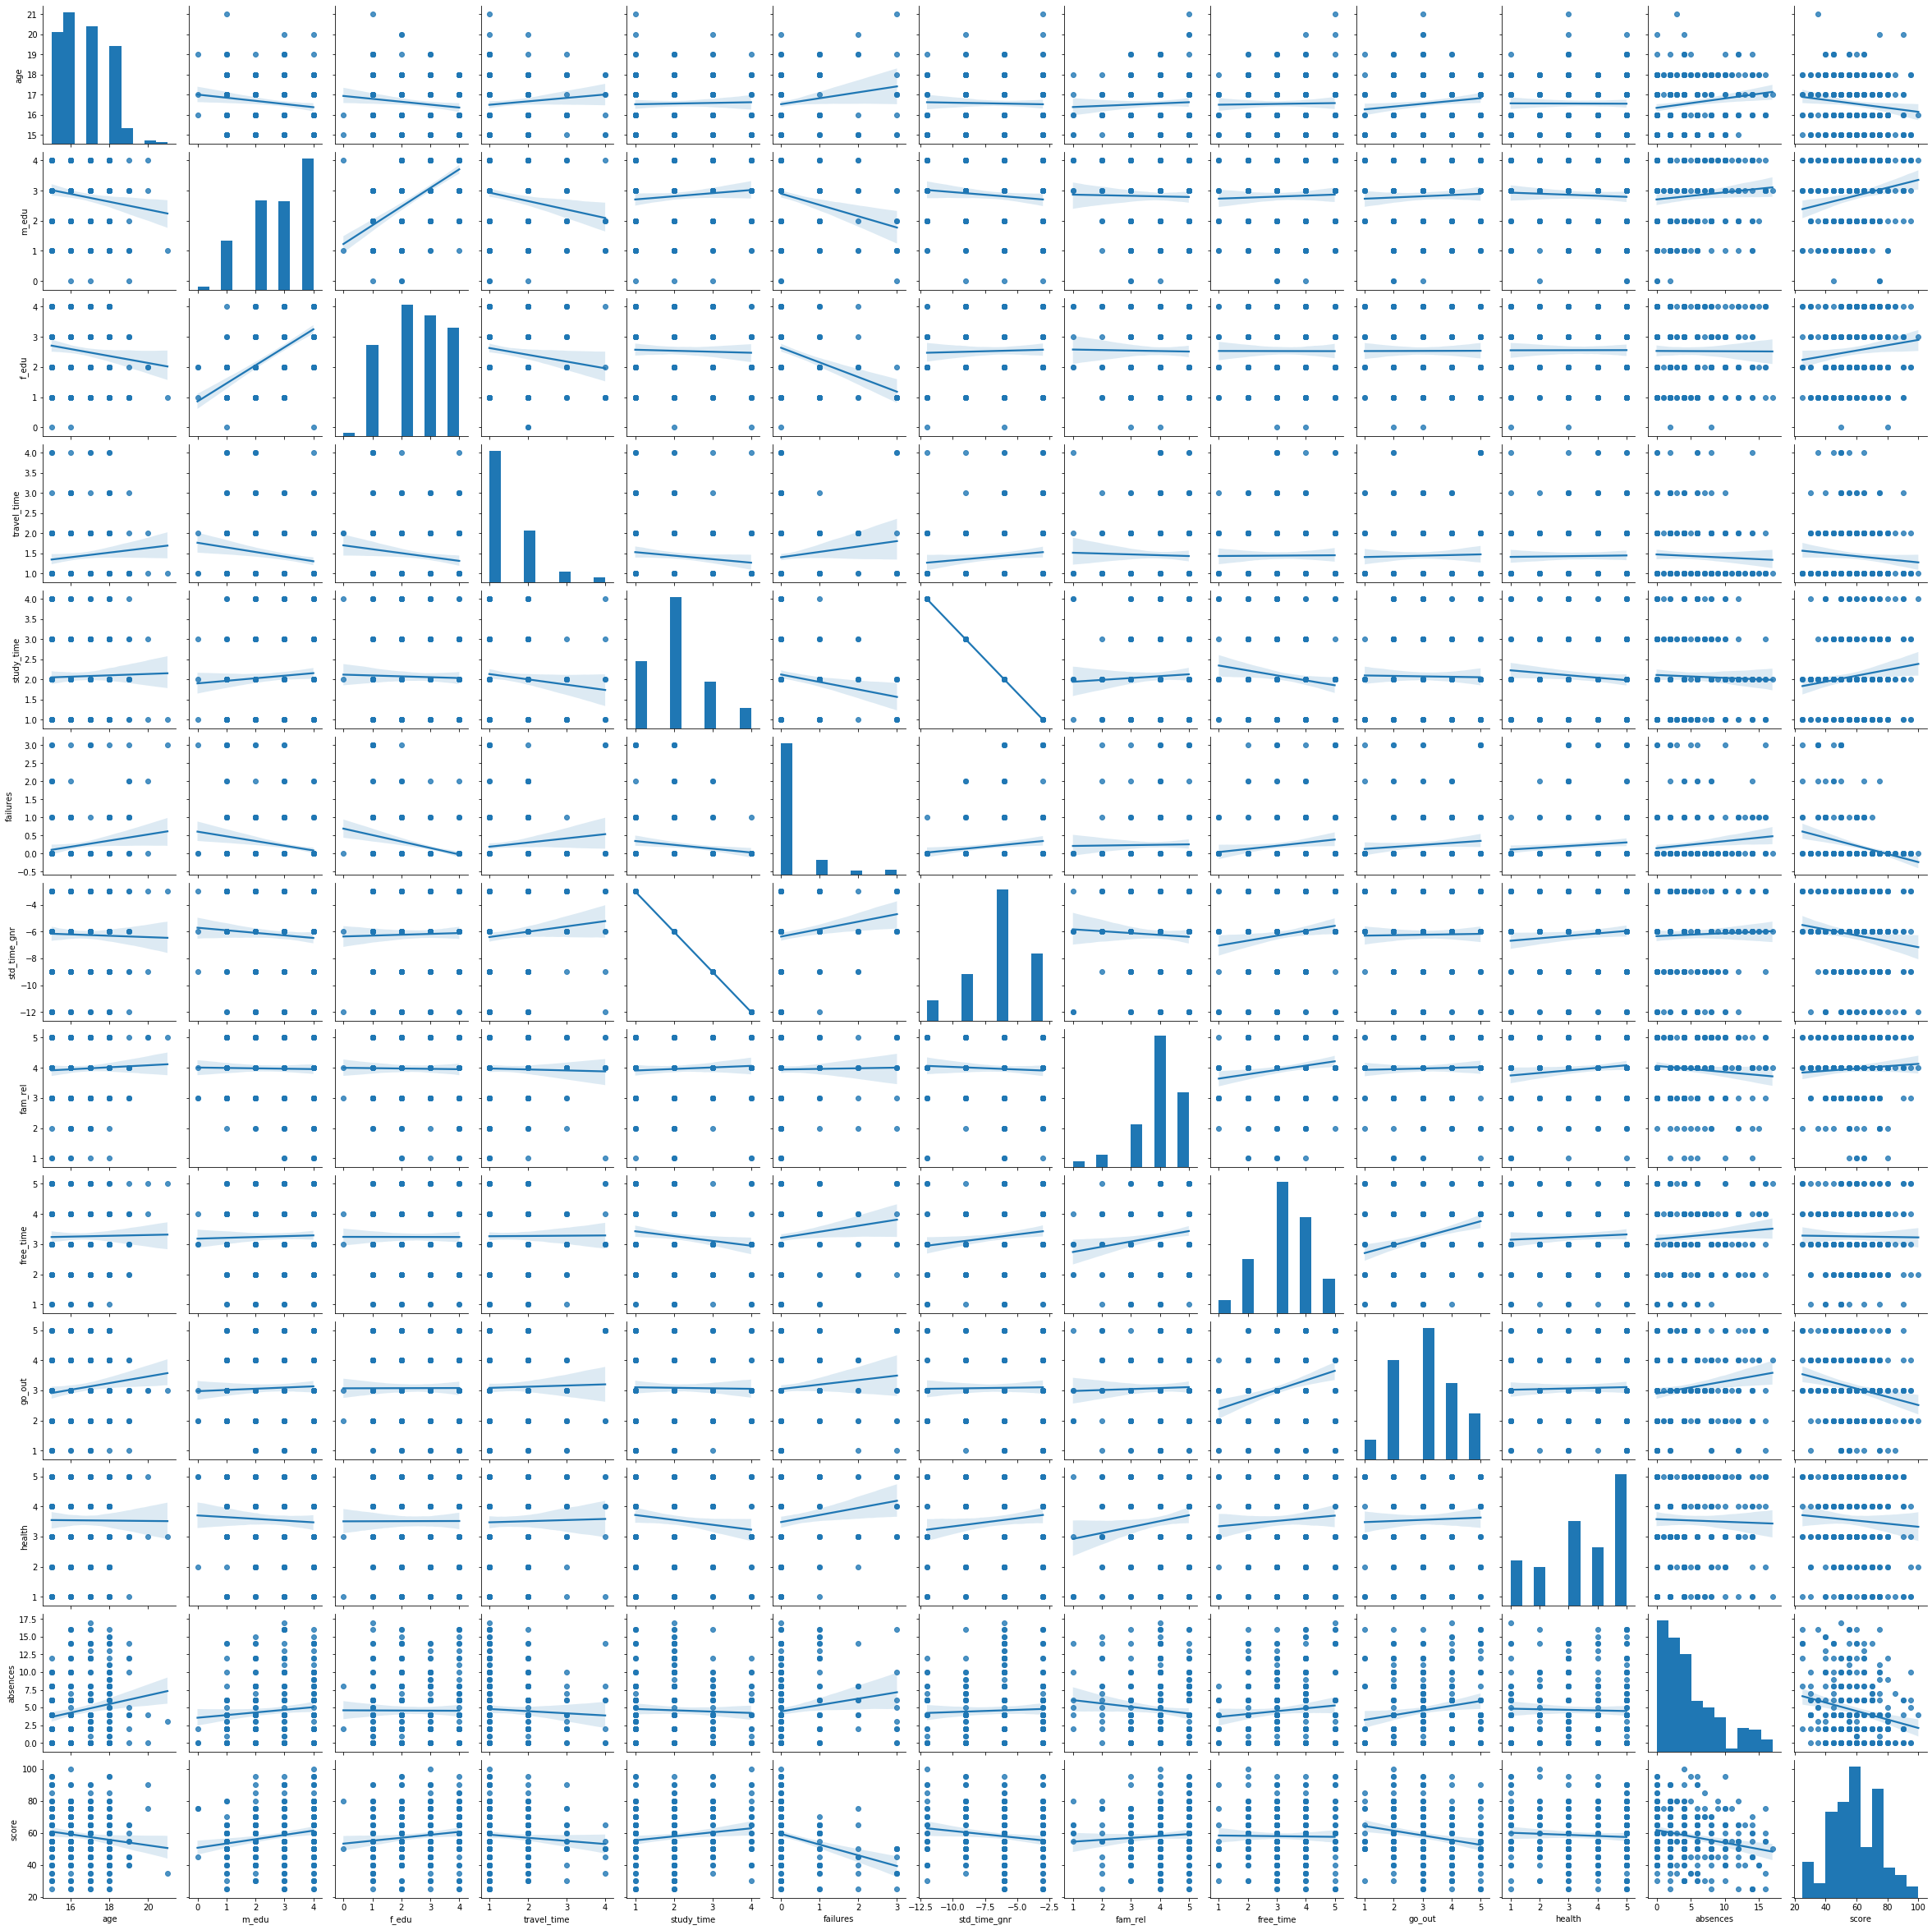

In [44]:
sns.pairplot(stud_math, kind = 'reg')

In [45]:
stud_math.corr() # Расчёт корреляционной матрицы

,age,m_edu,f_edu,travel_time,study_time,failures,std_time_gnr,fam_rel,free_time,go_out,health,absences,score
age,1.00,-0.14,-0.13,0.10,0.02,0.16,-0.02,0.04,0.02,0.12,-0.01,0.17,-0.13
m_edu,-0.14,1.00,0.61,-0.18,0.08,-0.22,-0.08,-0.02,0.03,0.04,-0.04,0.09,0.19
f_edu,-0.13,0.61,1.00,-0.15,-0.03,-0.29,0.03,-0.01,-0.00,0.00,0.00,-0.00,0.13
travel_time,0.10,-0.18,-0.15,1.00,-0.11,0.12,0.11,-0.03,0.01,0.03,0.02,-0.05,-0.09
study_time,0.02,0.08,-0.03,-0.11,1.00,-0.14,-1.00,0.05,-0.14,-0.01,-0.10,-0.04,0.14
failures,0.16,-0.22,-0.29,0.12,-0.14,1.00,0.14,0.02,0.13,0.09,0.11,0.13,-0.27
std_time_gnr,-0.02,-0.08,0.03,0.11,-1.00,0.14,1.00,-0.05,0.14,0.01,0.10,0.04,-0.14
fam_rel,0.04,-0.02,-0.01,-0.03,0.05,0.02,-0.05,1.00,0.16,0.03,0.13,-0.10,0.07
free_time,0.02,0.03,-0.00,0.01,-0.14,0.13,0.14,0.16,1.00,0.29,0.06,0.09,-0.01
go_out,0.12,0.04,0.00,0.03,-0.01,0.09,0.01,0.03,0.29,1.00,0.03,0.16,-0.20


### Какие основные выводы можно сделать из полученной корреляционной матрицы?
#### 1. Наблюдается полная обратная корреляционная зависимость между двумя параметрами: studytime (study_time) и studytime,granular (std_time_gnr): количественные показатели у обоих абсолютно одинаковые, включая количество пропущенных значений, отличаются только соответствующие обозначения. В параметре studytime они равны 1, 2, 3, 4, в параметре же studytime,granular -3, -6, -9, -12 соответственно, т.е. studytime,granular равен studytime, умноженному на минус 3. По сути параметры study_time и study_time,granular являются одинаковыми, только имеют различные обозначения и описание. Один из этих параметров мы можем исключить из дальнейшего анализа, им будет studytime,granular.
#### 2. На итоговую оценку по математике (score) наибольшее влияние оказывает 7 числовых параметров (с коэффициентом корреляции выше 0.1):
#### - возраст ученика (age): чем меньше возраст, тем легче даётся наука;
#### - образование родителей (m_edu, f_edu): чем образованнее родители, тем лучше успеваемость учеников. Очевидно, что родители с высшим образованием могут обеспечить гораздо лучшую интеллектуальную поддержку и помощь своему ребёнку;
#### - время, которое дополнительно тратит ученик на обучение (study_time): чем больше это время, тем лучше успехи (логично, не правда ли?)
#### - внеучебные неудачи (failures	) (внимание: наибольшее вляние!!!): чем больше неудач, чем хуже успеваемость (до учёбы ли, если другие проблемы не дают сосредоточиться на учёбе!)
#### - проведение времени с друзьями (go_out): друзья постоянно отвлекают от учёбы (особенно двоечники), то погулять сходить, то музыку послушать, то на тусовку срочно надо, то пивка попить и прочее, прочее, прочее... Когда тут учиться?
#### - количество пропущенных занятий (absences): чем меньше пропущенных занятий, тем лучше результат. Странно, не правда ли ? :)
### Эти семь вышеперечисленных параметров мы включаем в состав параметров для построения модели оценки
#### 3. Ряд параметров на оценку по госэкзамену по математике практически не влияет. Это: время в пути до школы (travel_time), семейные отношения (fam_rel), свободное время после школы (free_time) и состояние здоровья (health). Эти данные я бы исключил из дальнейшего анализа, как несущественные.
### Проанализируем дополнительно взаимосвязь между параметрами (столбцами):
#### 1. Возраст ученика: 
#### - сильная обратная корреляция с образованием родителей может говорить о том, что решение родителей о создании семьи и рождении детей  принималось в зависимости от окончания образования
#### - с возрастом у ученика всё больше всё больше возникает вероятность наделать глупостей (failures) (родителей мы уже не слушаемся, взрослые же !!!, пытаемся жить своим умом, а жизненного опыта не хватает)
#### - чем старше ученик, тем меньше ему хочется учиться и больше времени хочется проводить с друзьями, отсюда и прогулы занятий (absences), и жизненные неурядицы (failures), и, как результат, не очень хорошие итоговые оценки
#### 2. Образование родителей (m_edu и f_edu): 
#### - наблюдается сильная корреляция между этими двумя параметрами. Данный момент можно объяснить тем, что супружеские пары подбираются, как правило, по общности вкусов, интересов, взглядов, в том числе и уровню образования. При этом, образование матери положительно влияет на оценки гораздо больше, чем образование отца. Очевидно, что традиционно обязанность в помоще ребёнку по школе возлагается на мать. Теоретически, в случае необходимости, один из этих параметров можно исключить из дальнейшего анализа, тогда таким параметром должен стать f_edu, но пока мы этого делать не будем
#### - обратная корреляционная зависимость между образованием родителей и временем ученика на дорогу до школы может объясняться тем, что более образованные родители имеют более высокооплачиваемую работу и, соответственно, более высокое благосотояние, что позволяет ученику использовать для перемещения между домом и школой личный автотранспорт (семейные машины, такси), а не ходить пешком или пользоваться общественным транспортом
#### - прослеживавется устойчивая взаимосвязь между образованием родителей (m_edu и f_edu) и вероятностью попадания ученика в неприятную ситуацию (failures). Образованные интеллигентные родители сами не создадут и не вляпаются в неприятную ситуацию, и своего ребёнка оградят от неё, примером и советом
#### 3. Время на дорогу (travel_time): прямая корреляционная связь с количеством внеучебных неудач (failures) можно объяснить тем, что в дороге человека окружает множество людей, ученик оказывается в сосвершенно различных ситуациях, и вероятность попасть в какую-либо передрягу сильно возрастает
#### 4. Время на учёбу помимо школы (study_time): дополнительное увеличение времени на учёбу совершенно логически уменьшает количество свободного времени (free_time) и количество внеучебных неудач (failures) (становится просто некогда  искать приключения на свою голову и делать глупости)
#### 5. Количество внеучебных неудач (failures): при наличии большого количества свободного времени (free_time) его всегда хочется провести как-то интересно, отсюда поиск приключений и, как результат, более высокая вероятность попадания в неприятную ситуацию. А с друзьями таких приключений ещё больше!!! Когда неприятности и неудачи  (absences), какие могут быть уроки?
#### 6. При хороших семейных отношениях (fam_rel) хочется больше времени проводить в семейном кругу (free_time), а не искать приключения с друзьями (go_out). Спокойная доброжелательная семейная обстановка, отсутствие неприятностей (failures) вполне логично сказываются на общем состоянии здоровья (health).
#### 7. Видна сильная взаимосвязь между параметрами freetime и go_out (свободным временем учеников и времени, проведенном с друзьями), что вполне логично. При этом, наличие свободного времени, в отличие от общения с друзьями, практически не оказывает влияния на успеваемость учащихся.


In [46]:
'''Исключаем параметр std_time_gnr (studytime,granular) из дальнейшего анализа'''
stud_math.drop(['std_time_gnr'], inplace = True, axis = 1)

### Выводы:
### 1. Данные полные, достаточно чистые, Отдельные выбросы найдены в 4 столбцах: возраст (age), семейные отношения (fam_rel), образование отца (f_edu), количество пропущенных занятий (absences), что позволяет сделать вывод о том, что данные достаточно чистые. Проведена очистка данных.
### 2. Следующие семь параметров предлагается включить в состав параметров для построения модели оценки: age, m_edu, f_edu, study_time, failures, go_out, absences

###  
## ЭТАП 3
## Анализ и очистка номинативных показателей 

### Первоначально проанализируем количество уникальных и пропущенных значений

In [47]:
'''Вывод уникальных значений в столбцах номинативных переменных'''
print('Количество уникальных значений в столбцах номинативных переменных:')
i = 0

for clmn in stud_math.columns: # Цикл расчёта и выдачи количества уникальных значений номинативных столбцов
    if stud_math.loc[:, clmn].dtype == 'O':
        i += 1        
        print(i, clmn, ': ', stud_math.loc[:, clmn].nunique())

Количество уникальных значений в столбцах номинативных переменных:
1 school :  2
2 sex :  2
3 address :  2
4 fam_size :  2
5 p_status :  2
6 m_job :  5
7 f_job :  5
8 reason :  4
9 guardian :  3
10 school_sup :  2
11 fam_sup :  2
12 paid :  2
13 activities :  2
14 nursery :  2
15 higher :  2
16 internet :  2
17 romantic :  2


In [48]:
'''Или так...'''
stud_math.describe(include = ['O'])

,school,sex,address,fam_size,p_status,m_job,f_job,reason,guardian,school_sup,fam_sup,paid,activities,nursery,higher,internet,romantic
count,313,313,300,295,281,299,285,298,285,304,283,280,301,301,297,287,285
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,274,161,234,206,253,102,159,110,197,261,174,151,158,242,288,240,197


### Уникальных значений в столбцах номинативных переменных, оказывается, не так много (максимум - 5), в-основном, значения бинарные. Это позволяет нам не ограничивать количество выводимых переменных при построении графиков box-plot
### Для подготовка построения графиков проанализирум наличие в столбцах пропущенных и незаполненных значений:

In [49]:
'''Вывод количественных и пропущенных значений в столбцах номинативных переменных'''
for clmn in stud_math.columns: # Выводим данные в цикле по всем столбцам сразу
    if stud_math.loc[:, clmn].dtype == 'O': # Ищем только номинативные столбцы
        print('Параметр', clmn)
        prnt_quant(clmn)
        print(end='==========================\n\n')

Параметр school
Количество пропущенных значений: 0

Количественные показатели:
GP    274
MS     39
Name: school, dtype: int64

Параметр sex
Количество пропущенных значений: 0

Количественные показатели:
F    161
M    152
Name: sex, dtype: int64

Параметр address
Количество пропущенных значений: 13

Количественные показатели:
U    234
R     66
Name: address, dtype: int64

Параметр fam_size
Количество пропущенных значений: 18

Количественные показатели:
GT3    206
LE3     89
Name: fam_size, dtype: int64

Параметр p_status
Количество пропущенных значений: 32

Количественные показатели:
T    253
A     28
Name: p_status, dtype: int64

Параметр m_job
Количество пропущенных значений: 14

Количественные показатели:
other       102
services     78
teacher      46
at_home      44
health       29
Name: m_job, dtype: int64

Параметр f_job
Количество пропущенных значений: 28

Количественные показатели:
other       159
services     77
teacher      22
at_home      14
health       13
Name: f_job, dtyp

### К нашему удолетворению, данные в номинативных столбцах оказались достаточно полные, незаполненных значений нет, пропущенных значений не так много, их заполнить не получится, так как мало данных. Преобразовывать данные нет необходимости
### Далее строим графики box-plot и одновременно для каждого параметра рассчитываем статистическую разницу в распределении оценок с помощью теста Стьюдента:

Параметр school


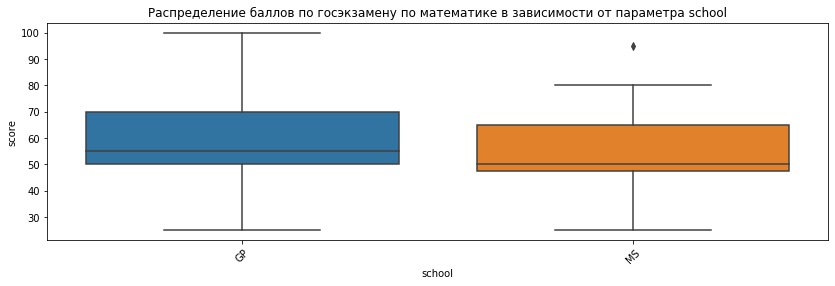

Статистически значимые различия для параметра school не найдены

Параметр sex


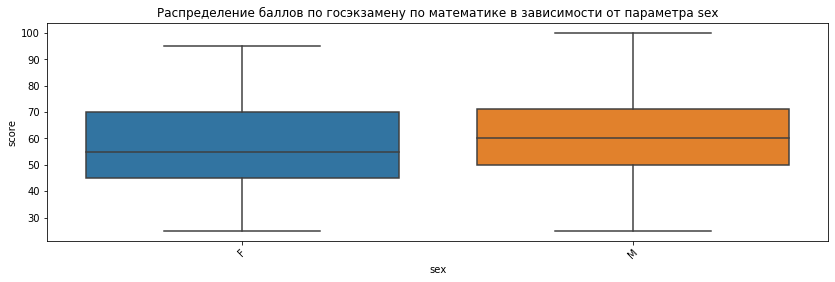

Найдены статистически значимые различия для параметра sex

Параметр address


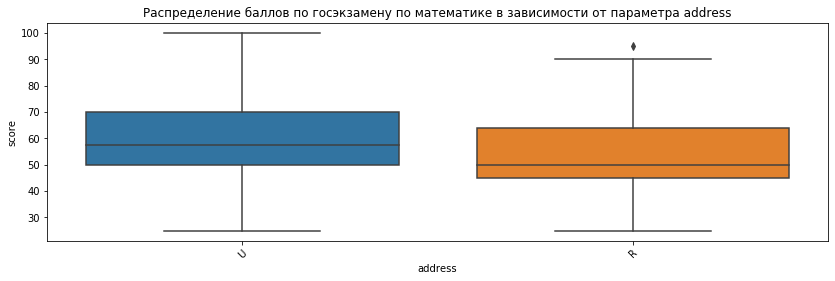

Найдены статистически значимые различия для параметра address

Параметр fam_size


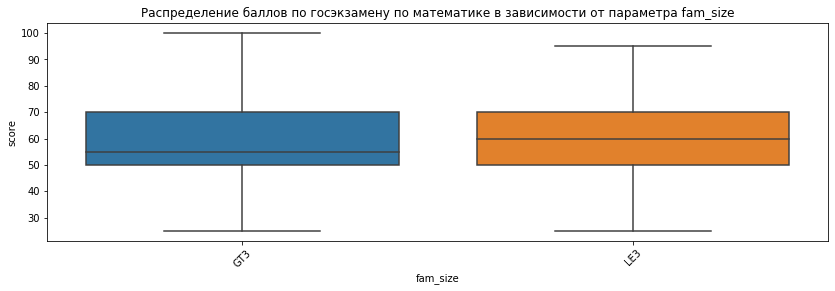

Статистически значимые различия для параметра fam_size не найдены

Параметр p_status


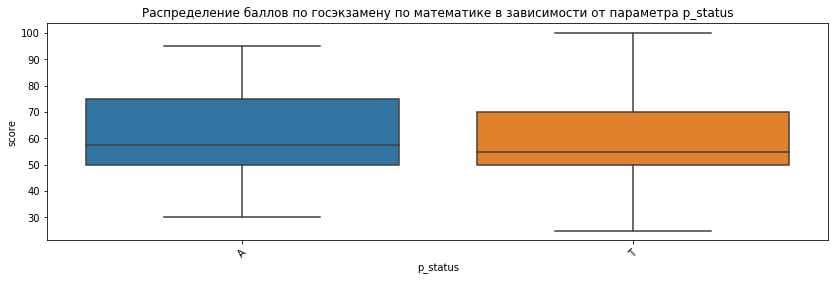

Статистически значимые различия для параметра p_status не найдены

Параметр m_job


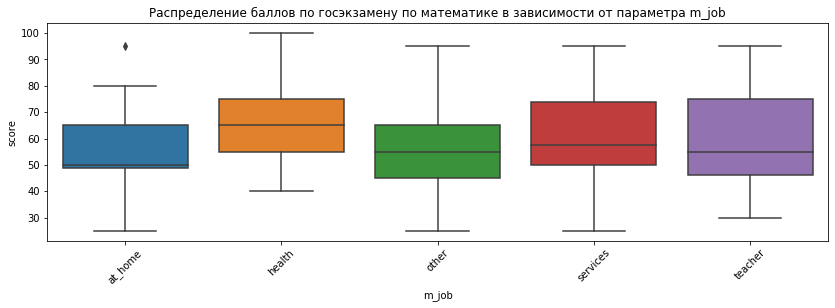

Найдены статистически значимые различия для параметра m_job

Параметр f_job


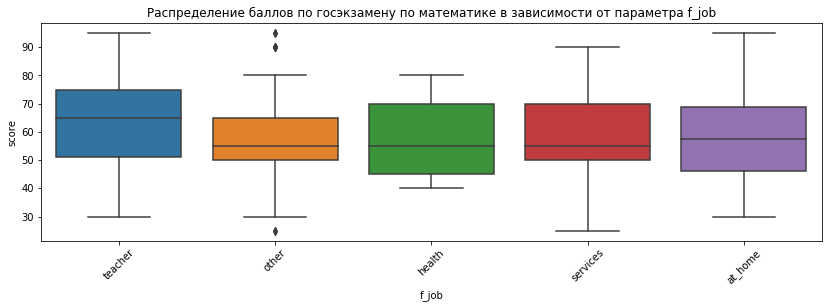

Статистически значимые различия для параметра f_job не найдены

Параметр reason


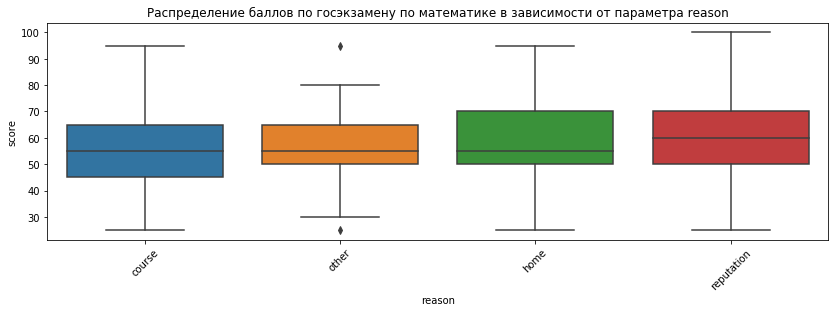

Статистически значимые различия для параметра reason не найдены

Параметр guardian


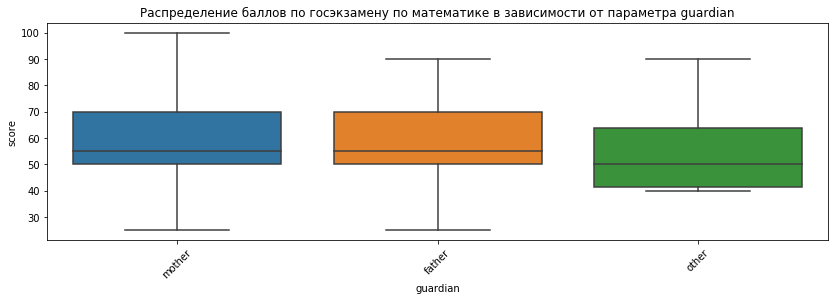

Статистически значимые различия для параметра guardian не найдены

Параметр school_sup


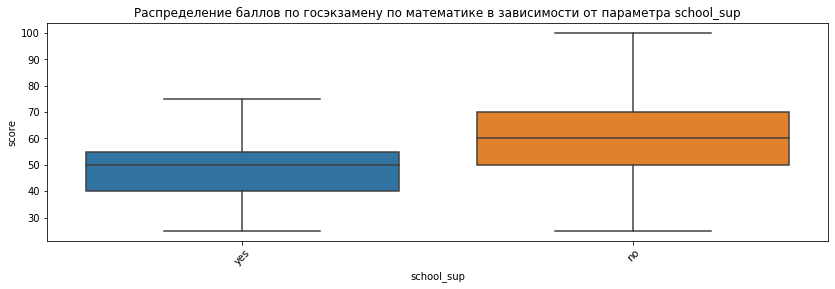

Найдены статистически значимые различия для параметра school_sup

Параметр fam_sup


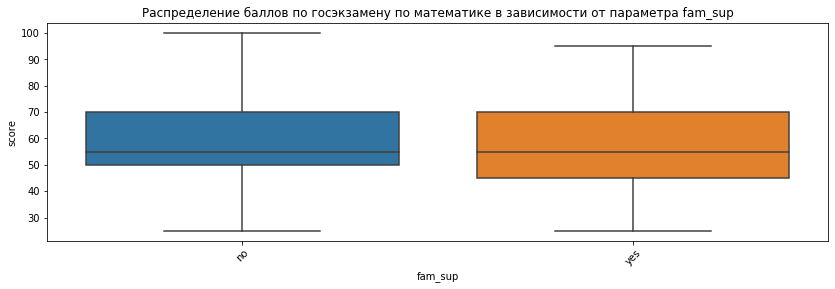

Статистически значимые различия для параметра fam_sup не найдены

Параметр paid


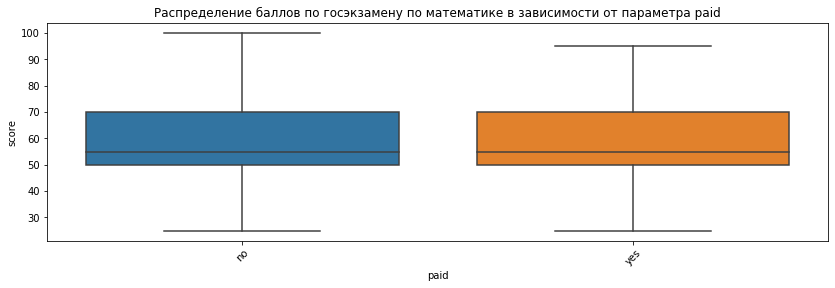

Статистически значимые различия для параметра paid не найдены

Параметр activities


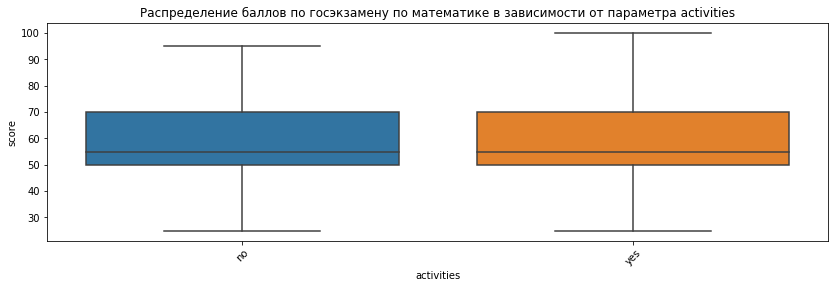

Статистически значимые различия для параметра activities не найдены

Параметр nursery


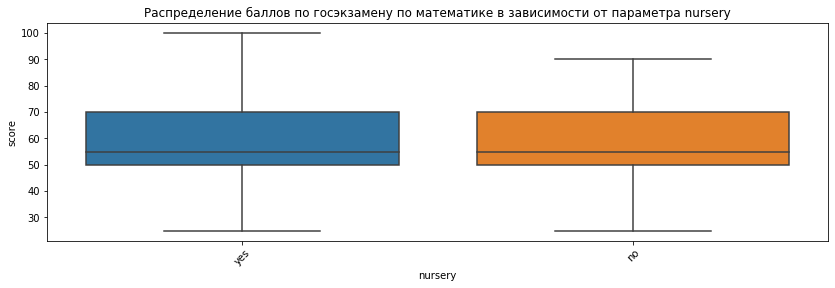

Статистически значимые различия для параметра nursery не найдены

Параметр higher


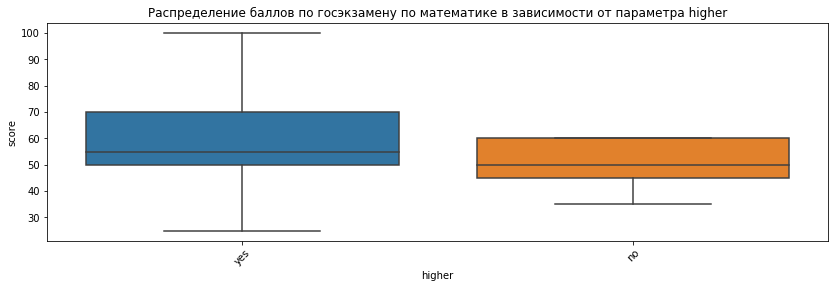

Статистически значимые различия для параметра higher не найдены

Параметр internet


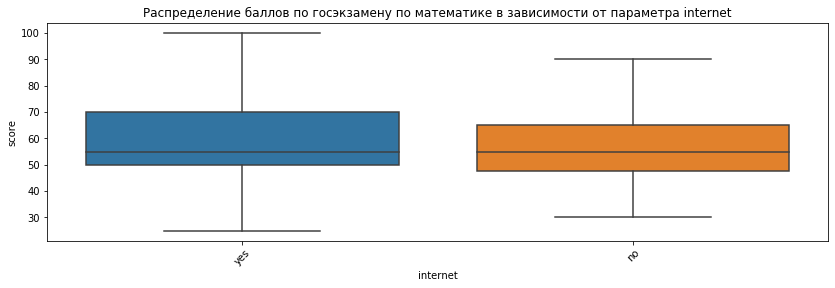

Статистически значимые различия для параметра internet не найдены

Параметр romantic


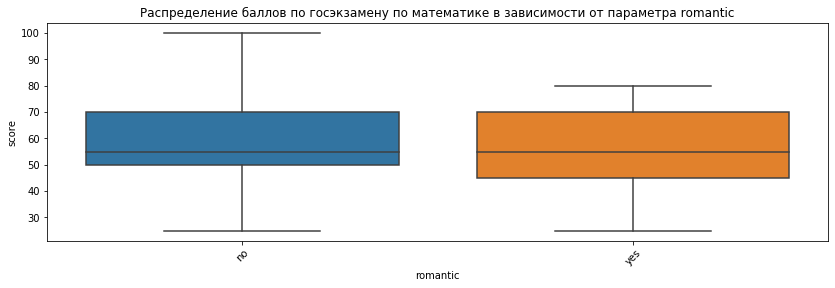

Статистически значимые различия для параметра romantic не найдены



In [50]:
for clmn in stud_math.columns: # Организуем цикл по всем столбцам сразу
    if stud_math.loc[:, clmn].dtype == 'O': # Ищем только номинативные столбцы
        print('Параметр', clmn)
        
        data_boxplot(clmn) # Построение графика box-plot
        data_stat_dif(clmn) # Расчет и вывод статистически значимых различий для параметра
        
        print(end='=======================================================================================================\n\n')

### Из анализа графиков видно, что у 5 параметров: school, address, m_job, f_job, reason, есть в сумме 8 выбросов. При этом, 4 параметра: sex, address, m_job, school_sup, имеют статистически значимые различия данных для оценки влияния успеваемости

### В статистически значимых столбцах имеется всего по одному выбросу: в параметре 'R' в столбце address и в параметре 'at_home' в столбце m_job. Проанализируем эти выбросы

Параметр address

50.00    17
55.00     8
65.00     7
60.00     6
35.00     6
25.00     4
40.00     4
70.00     3
80.00     3
30.00     2
45.00     2
75.00     2
95.00     1
90.00     1
Name: score, dtype: int64

Статистические данные:
count   66.00
mean    53.18
std     15.48
min     25.00
25%     45.00
50%     50.00
75%     63.75
max     95.00
Name: score, dtype: float64

Границы выбросов: [16.875, 91.875]


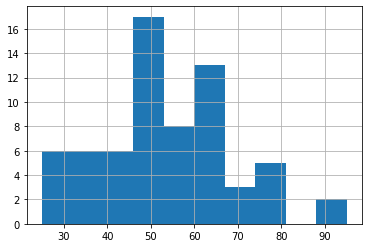

In [51]:
'''Анализ параметра address'''
tmp_add = stud_math[stud_math.address == 'R']
print('Параметр address\n', tmp_add.score.value_counts(), sep='\n')
stat_add = tmp_add.score.describe()
brd_bl_add = board_blowout(stat_add) # Определяем границы выбросов

print('\nСтатистические данные:', stat_add, sep='\n')
print('\nГраницы выбросов:', brd_bl_add)

tmp_add.score.hist() # Строим гистограмму

Параметр address

50.00    15
65.00     5
30.00     4
60.00     3
75.00     3
40.00     3
70.00     3
45.00     3
55.00     2
80.00     1
95.00     1
25.00     1
Name: score, dtype: int64

Статистические данные:
count   44.00
mean    53.98
std     14.77
min     25.00
25%     48.75
50%     50.00
75%     65.00
max     95.00
Name: score, dtype: float64

Границы выбросов: [24.375, 89.375]


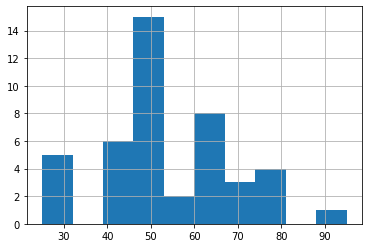

In [52]:
'''Анализ параметра m_job'''
tmp_mj = stud_math[stud_math.m_job == 'at_home']
print('Параметр address\n', tmp_mj.score.value_counts(), sep='\n')
stat_mj = tmp_mj.score.describe()
brd_bl_mj = board_blowout(stat_mj) # Определяем границы выбросов

print('\nСтатистические данные:', stat_mj, sep='\n')
print('\nГраницы выбросов:', brd_bl_mj)

tmp_mj.score.hist() # Строим гистограмму

### Из анализа данных видно, что в обоих столбцах выброс имеет одно и то же значение - 95. Выведем их

In [53]:
display(stud_math[(stud_math.address == 'R') & (stud_math.score == 95)], 
        stud_math[(stud_math.m_job == 'at_home') & (stud_math.score == 95)])

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
374,MS,F,18.00,R,LE3,T,4.00,nan,other,NaN,reputation,mother,2.00,3.00,0.00,no,no,no,no,yes,yes,yes,no,5.00,4.00,4.00,1.00,0.00,95.00


,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
286,GP,F,18.00,U,GT3,T,2.00,nan,at_home,at_home,other,mother,1.00,3.00,0.00,no,yes,yes,no,yes,yes,yes,no,4.00,3.00,3.00,2.00,5.00,95.00


### Записи разные, с номерами 286 и 374. Удаляем их

In [54]:
stud_math.drop([286, 374], inplace = True, axis = 0)

### Проверяем полученный результат

Параметр school


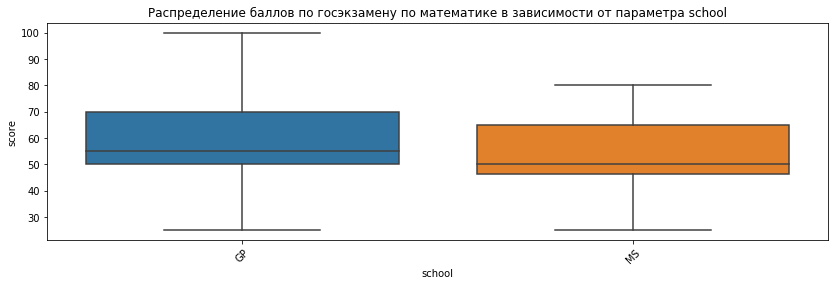

Статистически значимые различия для параметра school не найдены

Параметр sex


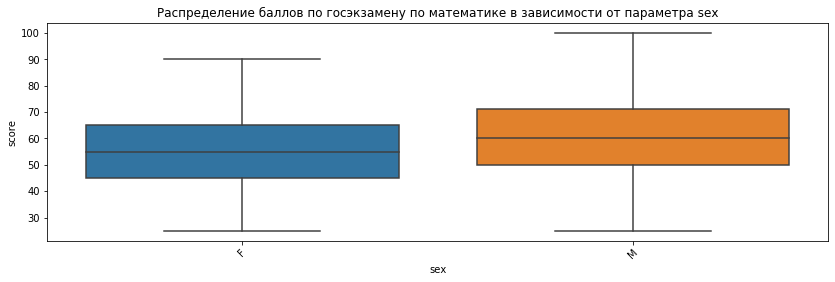

Найдены статистически значимые различия для параметра sex

Параметр address


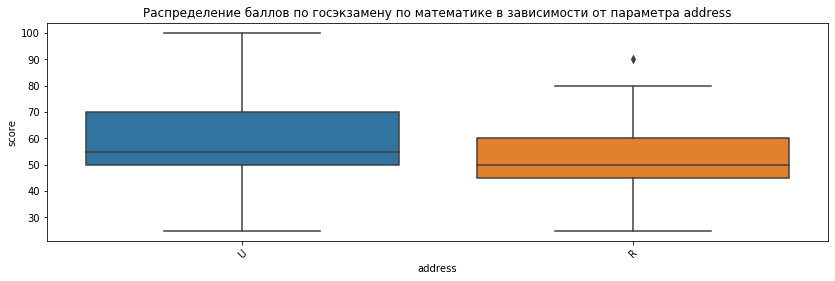

Найдены статистически значимые различия для параметра address

Параметр fam_size


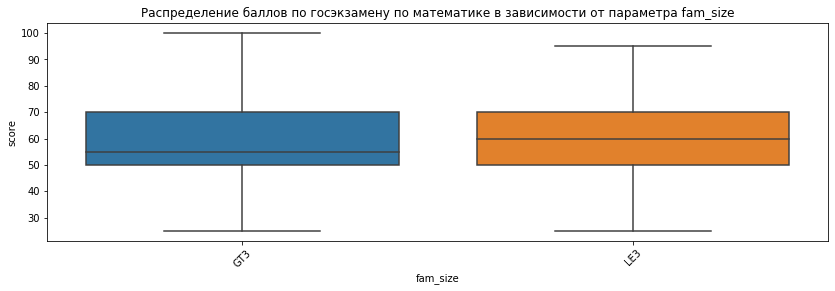

Статистически значимые различия для параметра fam_size не найдены

Параметр p_status


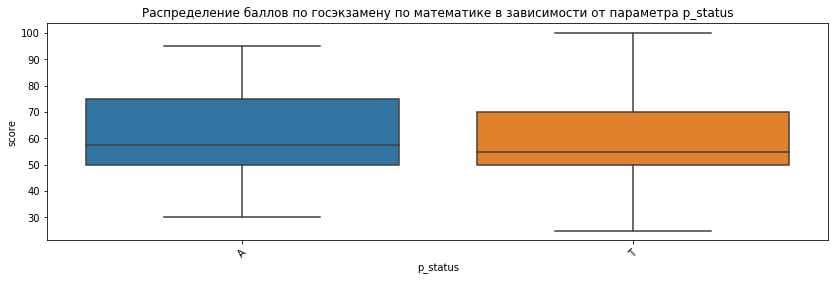

Статистически значимые различия для параметра p_status не найдены

Параметр m_job


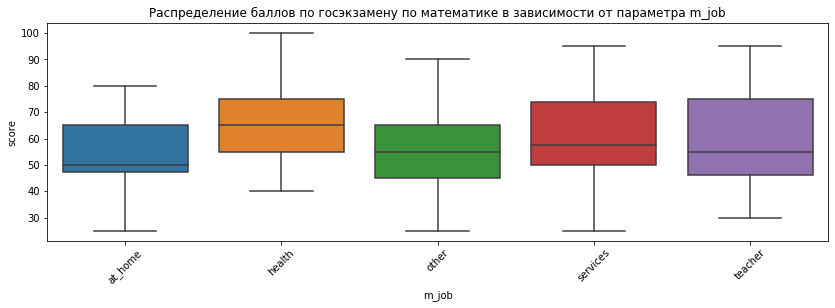

Найдены статистически значимые различия для параметра m_job

Параметр f_job


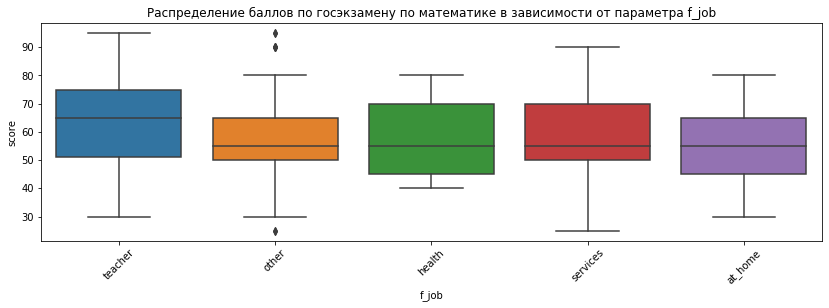

Статистически значимые различия для параметра f_job не найдены

Параметр reason


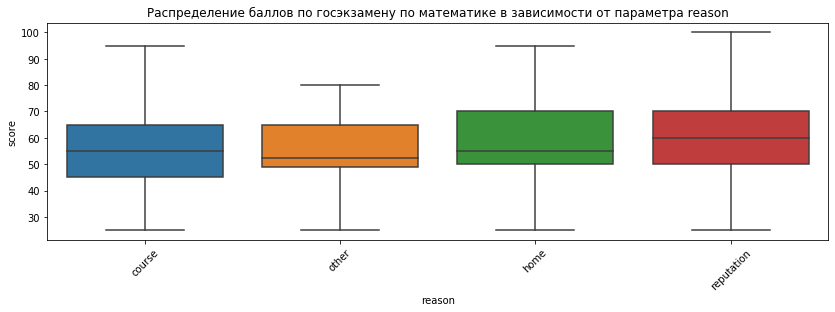

Статистически значимые различия для параметра reason не найдены

Параметр guardian


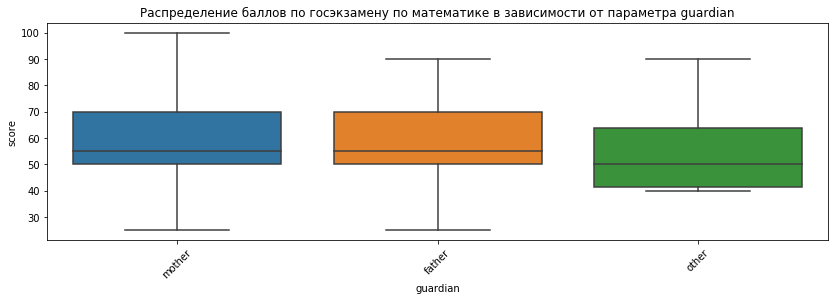

Статистически значимые различия для параметра guardian не найдены

Параметр school_sup


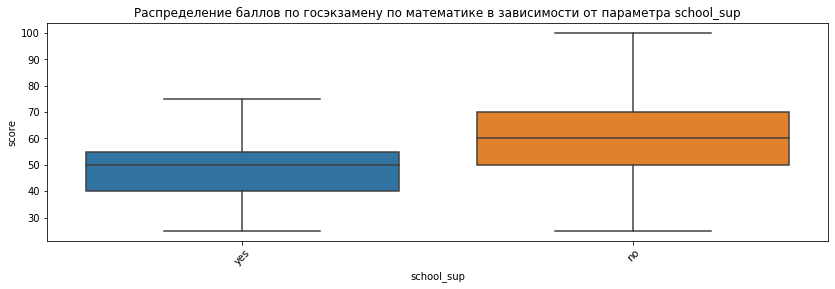

Найдены статистически значимые различия для параметра school_sup

Параметр fam_sup


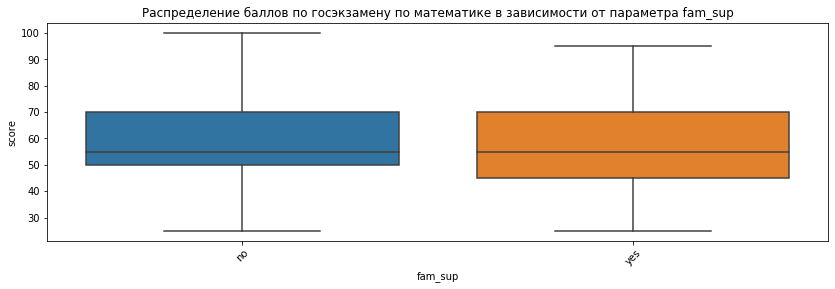

Статистически значимые различия для параметра fam_sup не найдены

Параметр paid


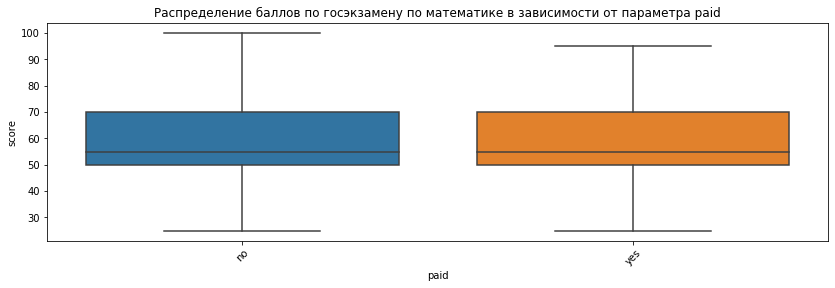

Статистически значимые различия для параметра paid не найдены

Параметр activities


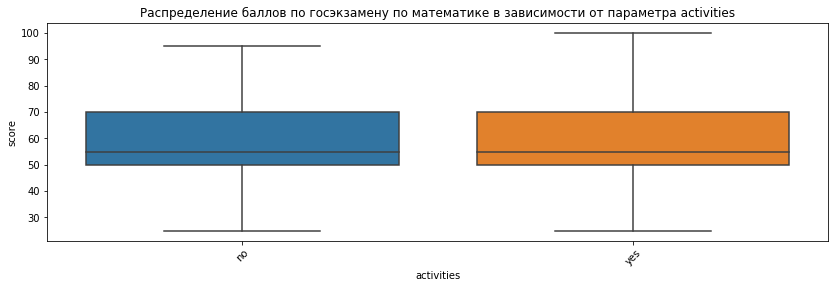

Статистически значимые различия для параметра activities не найдены

Параметр nursery


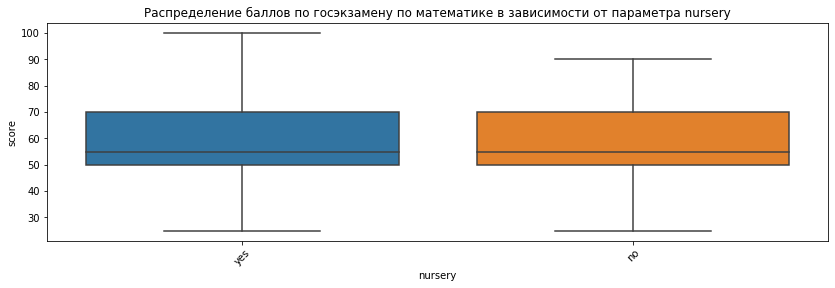

Статистически значимые различия для параметра nursery не найдены

Параметр higher


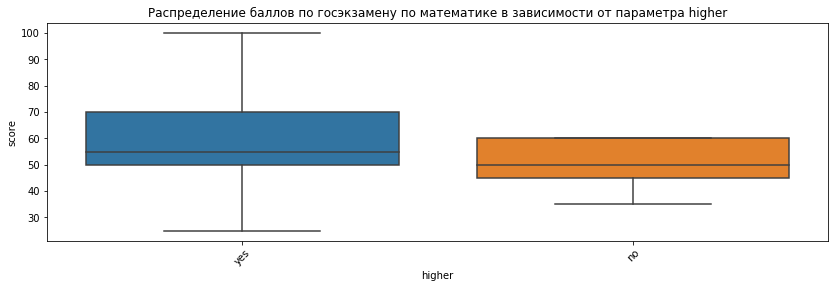

Статистически значимые различия для параметра higher не найдены

Параметр internet


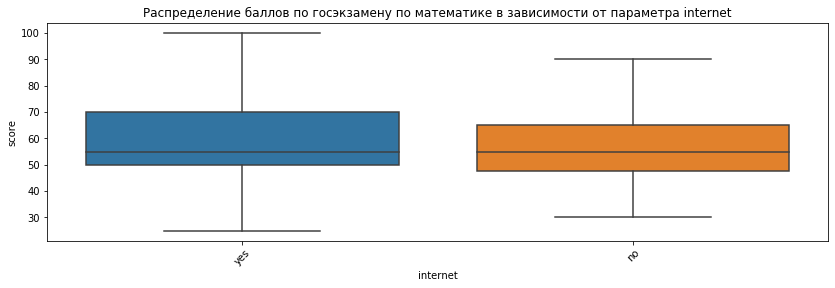

Статистически значимые различия для параметра internet не найдены

Параметр romantic


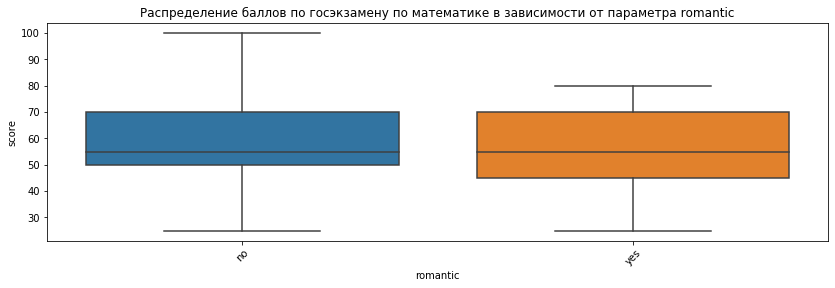

Статистически значимые различия для параметра romantic не найдены



In [55]:
'''Проверяем полученный результат'''
for clmn in stud_math.columns: # Цикл по всем столбцам
    if stud_math.loc[:, clmn].dtype == 'O': # Фильтруем номинативные столбцы
        print('Параметр', clmn)
        
        data_boxplot(clmn)
        data_stat_dif(clmn)
        
        print(end='=======================================================================================================\n\n')

### В столбце m_job от выброса избавиться удалось. Зато в столбце address появился новый выброс. Похоже, что после удаления записи произошло смещение статистических значений. Проверяем:

Параметр address

50.00    17
55.00     8
65.00     7
60.00     6
35.00     6
25.00     4
40.00     4
70.00     3
80.00     3
30.00     2
45.00     2
75.00     2
90.00     1
Name: score, dtype: int64

Статистические данные:
count   65.00
mean    52.54
std     14.69
min     25.00
25%     45.00
50%     50.00
75%     60.00
max     90.00
Name: score, dtype: float64

Границы выбросов: [22.5, 82.5]


,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
293,GP,F,17.00,R,LE3,T,3.00,1.00,services,other,reputation,mother,2.00,4.00,0.00,no,yes,yes,no,yes,yes,no,NaN,3.00,1.00,2.00,3.00,6.00,90.00


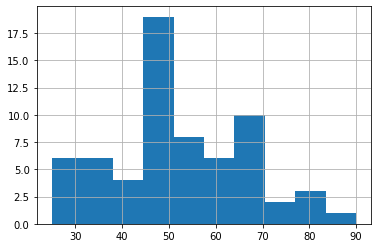

In [56]:
'''Анализ параметра address'''
tmp_add = stud_math[stud_math.address == 'R']
print('Параметр address\n', tmp_add.score.value_counts(), sep='\n')
stat_add = tmp_add.score.describe()
brd_bl_add = board_blowout(stat_add) # Определяем границы выбросов

print('\nСтатистические данные:', stat_add, sep='\n')
print('\nГраницы выбросов:', brd_bl_add)

tmp_add.score.hist() # Строим гистограмму
stud_math[(stud_math.address == 'R') & (stud_math.score == 90)]

### Так и есть: нижняя граница выбросов ушла вниз. Попробуем убрать очередной выброс и посмотрим, что из этого получится

In [57]:
stud_math.drop(stud_math.loc[(stud_math['address']=='R') & (stud_math.score == 90)].index, inplace=True)

Параметр school


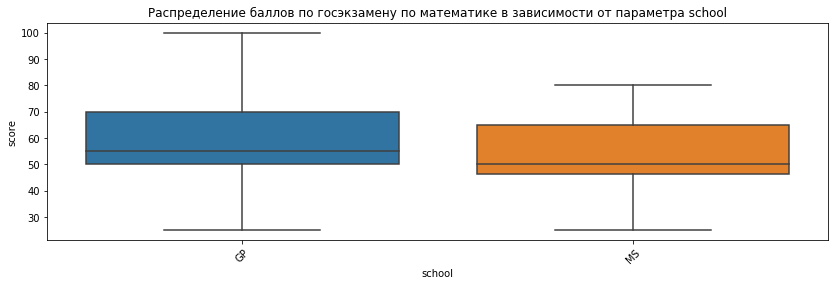

Статистически значимые различия для параметра school не найдены

Параметр sex


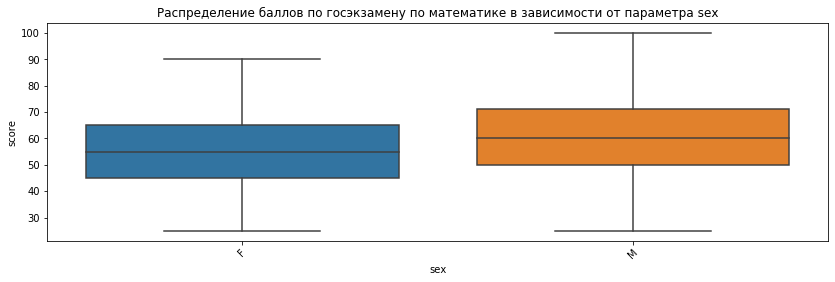

Найдены статистически значимые различия для параметра sex

Параметр address


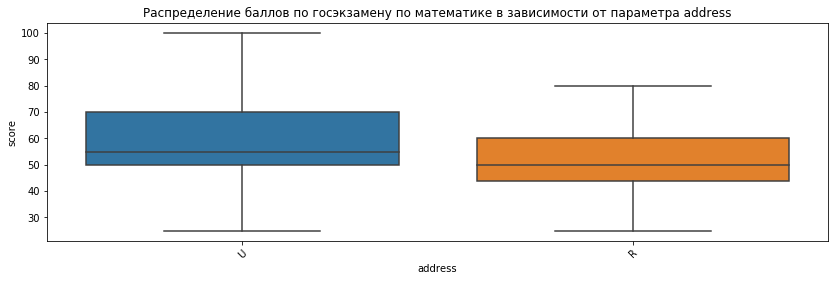

Найдены статистически значимые различия для параметра address

Параметр fam_size


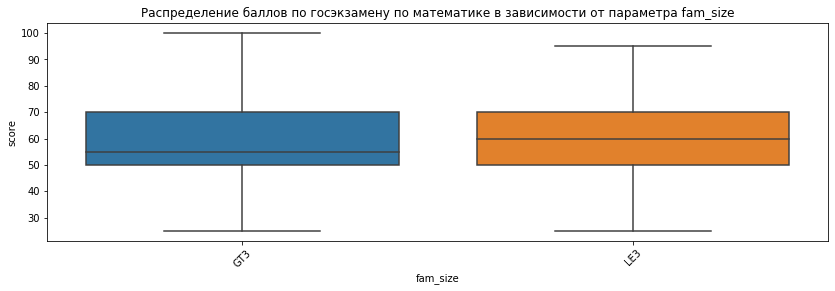

Статистически значимые различия для параметра fam_size не найдены

Параметр p_status


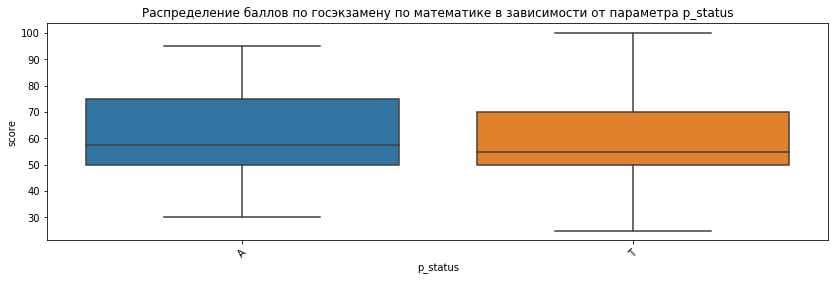

Статистически значимые различия для параметра p_status не найдены

Параметр m_job


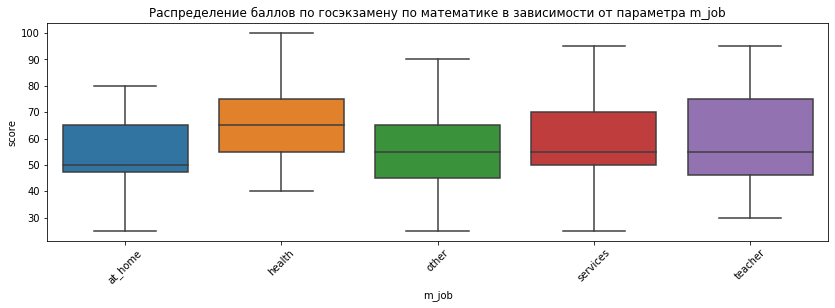

Найдены статистически значимые различия для параметра m_job

Параметр f_job


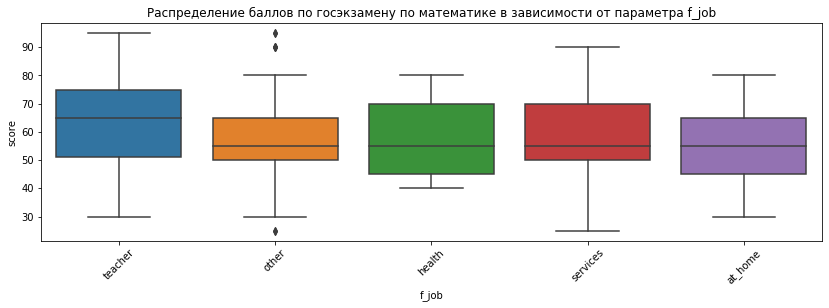

Статистически значимые различия для параметра f_job не найдены

Параметр reason


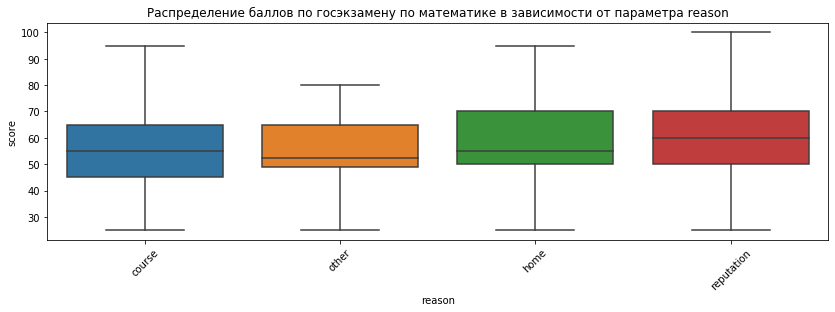

Статистически значимые различия для параметра reason не найдены

Параметр guardian


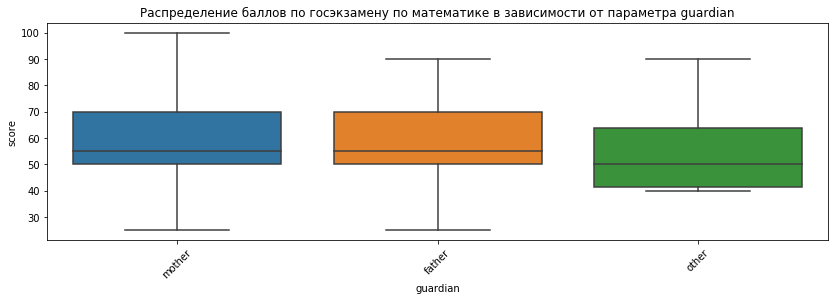

Статистически значимые различия для параметра guardian не найдены

Параметр school_sup


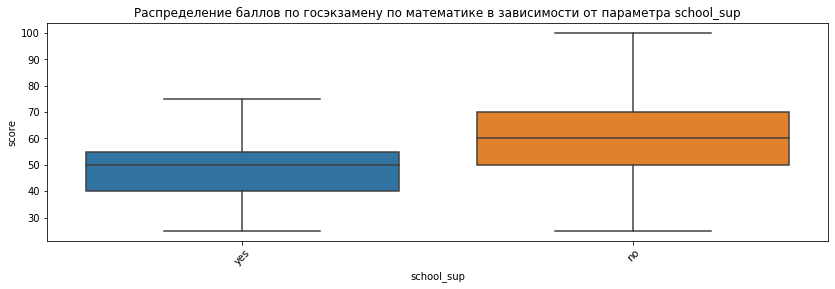

Найдены статистически значимые различия для параметра school_sup

Параметр fam_sup


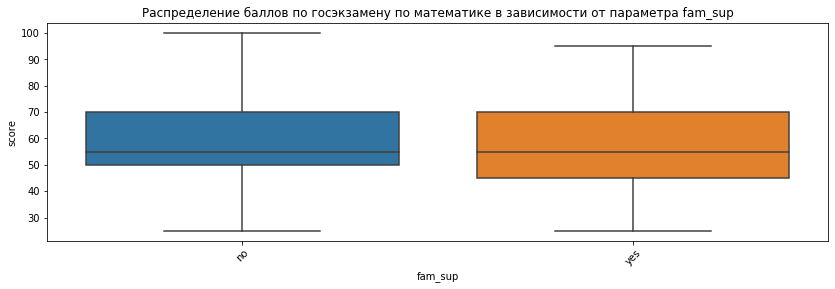

Статистически значимые различия для параметра fam_sup не найдены

Параметр paid


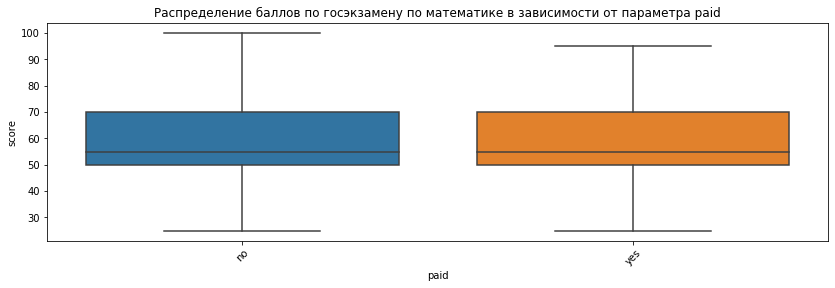

Статистически значимые различия для параметра paid не найдены

Параметр activities


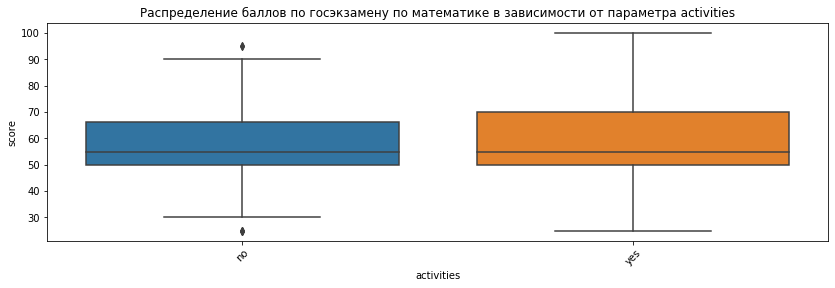

Статистически значимые различия для параметра activities не найдены

Параметр nursery


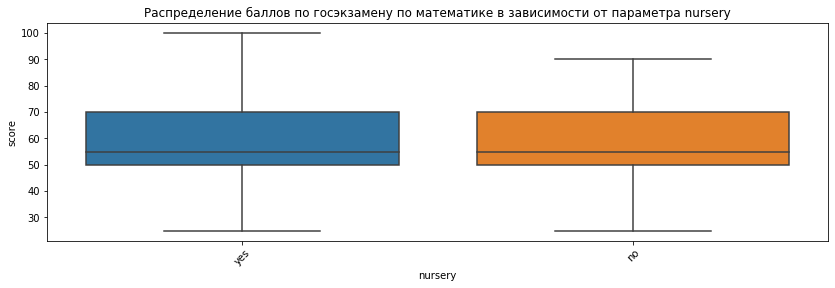

Статистически значимые различия для параметра nursery не найдены

Параметр higher


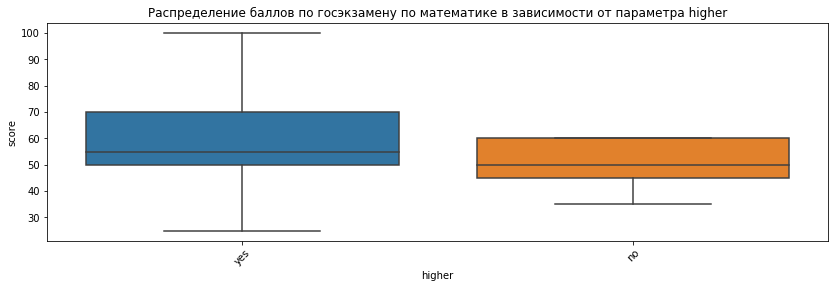

Статистически значимые различия для параметра higher не найдены

Параметр internet


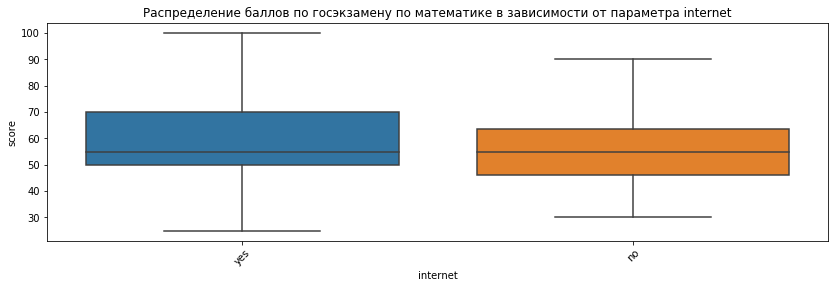

Статистически значимые различия для параметра internet не найдены

Параметр romantic


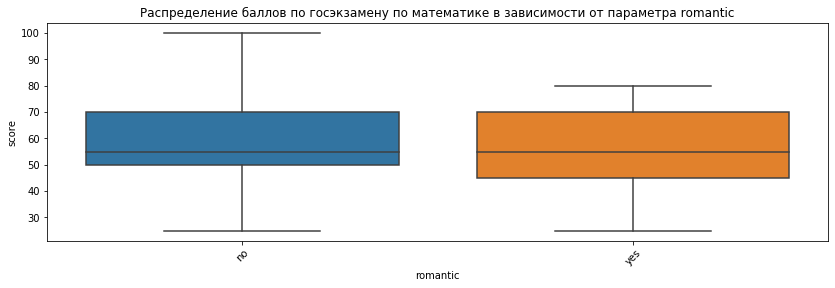

Статистически значимые различия для параметра romantic не найдены



In [58]:
'''Проверяем полученный результат'''
for clmn in stud_math.columns:
    if stud_math.loc[:, clmn].dtype == 'O':
        print('Параметр', clmn)
        
        data_boxplot(clmn)
        data_stat_dif(clmn)
        
        print(end='=======================================================================================================\n\n')

### О, чудо! В статистически значимых параметрах не осталось ни одного выброса!

### Выводы: 
### 1. Данные полные, достаточно чистые, имелись отдельные выбросы у параметров school, address, m_job, f_job и reason. Была проведена очистка данных по параметрам address и m_job, как имеющим статистически значимые различия данных для оценки влияния успеваемости
### 2. По параметрам:
#### - school :  подавляющее число учеников (почти 88%), участвующих в анализе, посещают одну школу
#### - sex :  учеников женского и мужского пола примерно одинаковое количество
#### - address :  три четверти учеников (78%) живет в городе
#### - fam_size :  число семей с количеством членов больше трех больше почти в 2,5 раза
#### - p_status :  практически все семьи полные (почти 90%)
#### - m_job :  работа матерей распределена достаточно равномерно, немного больше работает в сфере услуг
#### - f_job :  основное количество отцов работает в сфере услуг и по другим специальностям (83%)
#### - reason :  основные причины выбора школы распределены примерно равномерно, однако образовательная программа является приоритетной (наверное, по этой причине школа "GP" пользуется бОльшей популярностью)
#### - guardian :  в подавляющем числе семей (почти 70%) основную помощь учащемуся оказывают матери, и только в 26% - отцы
#### - school_sup :  основное количество учеников (86%) учатся без дополнительной образовательной поддержки со стороны школы
#### - fam_sup :  более половины учеников обращаются за помощью к семье по учёбе
#### - paid :  чуть больше половины учеников не пользуются дополнительными платными уроками по математике, справляются с учебным процессом самостоятельно
#### - activities :  дополнительные учебные занятия посещает немногим более половины учеников
#### - nursery :  80% учеников посещали перед школой детский сад
#### - higher :  подавляющее число учеников (96%) хотят получить высшее образование
#### - internet :  интернет дома установлен всего у 84% учеников (зависит, наверное, от материального благостояния семей, либо религиозных взглядов)
#### - romantic :  состояние влюблённости у 69% учеников (наверное, больше, только не все готовы признаться в этом)
### 3. Статистически значимые различия данных для оценки влияния успеваемости найдены у следующих столбцов: sex, address, m_job, school_sup, их мы включаем в состав параметров для построения модели оценки успеваемости по математике
###  

# ЭТАП 4
# Подводим основные итоги, делаем выводы

### Итак, в результате EDA для анализа влияния условий жизни учеников учащихся в возрасте от 15 до 22 лет на их успеваемость по математике были получены следующие выводы:
### 1. В данных относительно мало пропущенных значений (менее 1%)
### 2. Данные достаточно чистые, отдельные выбросы найдены в 9 столбцах: возраст (age), образование отца (f_edu), семейные отношения (fam_rel), количество пропущенных занятий (absences), школа обучения (school), адрес (address), работа матери (m_job), работа отца (f_job), причина выбора школы (reason), что позволяет сделать вывод о том, что данные достаточно чистые. Проведена очистка данных. Несущественные выбросы остались только в двух статистически незначимых столбцах с номинативными данными: f_job и reason 
### 3. Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели оценки результатов госэкзамена по математике, это: age, m_edu, f_edu, study_time, failures, go_out, absences, sex, address, m_job и school_sup
###  

In [59]:
# Формируем датасет для построения модели оценки успеваемости по математике
stud_math_for_model = stud_math.loc[:, ['age', 'm_edu', 'f_edu', 'study_time', 'failures', 'go_out', 
                                        'absences', 'sex', 'address', 'm_job', 'school_sup', 'score']]
stud_math_for_model.head() # Проверяем формирование датасета

,age,m_edu,f_edu,study_time,failures,go_out,absences,sex,address,m_job,school_sup,score
0,18.00,4.00,4.00,2.00,0.00,4.00,6.00,F,U,at_home,yes,30.00
1,17.00,1.00,1.00,2.00,0.00,3.00,4.00,F,U,at_home,no,30.00
2,15.00,1.00,1.00,2.00,3.00,2.00,10.00,F,U,at_home,yes,50.00
3,15.00,4.00,2.00,3.00,0.00,2.00,2.00,F,U,health,no,75.00
4,16.00,3.00,3.00,2.00,0.00,2.00,4.00,F,U,other,no,50.00
